In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import time
import shap
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from pandas_profiling import ProfileReport

pd.options.display.max_rows = 300
pd.options.display.max_columns = 100

In [397]:
df = pd.read_csv("data/nba.csv")
champions = pd.read_csv('data/champions.csv')

In [398]:
champ_dict = {'BOS':'Boston Celtics', 'CHI':'Chicago Bulls', 'CLE':'Cleveland Cavaliers',
 'DAL':'Dallas Mavericks','DET' : 'Detroit Pistons', 'GSW':'Golden State Warriors',
 'HOU':'Houston Rockets', 'IND':'Indiana Pacers','KCO':'Kentucky Colonels',
 'LAL':'Los Angeles Lakers','MIA':'Miami Heat', 'MIL':'Milwaukee Bucks',
 'MNL':'Minneapolis Lakers','NYK':'New York Knicks','NYN':'New York Nets',
 'PHI':'Philadelphia 76ers','PHW':'Philadelphia Warriors', 'SAS':'San Antonio Spurs',
 'SEA':'Seattle SuperSonics','STL':'St. Louis Hawks','SYR':'Syracuse Nationals',
 'TOR':'Toronto Raptors', 'WSB':'Washington Bullets','BLB':'Baltimore Bullets'}
c_acr = list(champ_dict.keys())
c_val = list(champ_dict.values())
cdf = pd.DataFrame({'acronym':c_acr,'Champion':c_val})
champions = champions.merge(right = cdf, on = 'Champion', how = 'left')
champions = champions.loc[champions.Lg == 'NBA'].copy()

In [399]:
def add_HOF(df):
    df.loc[df.name == 'Tracy McGrady','Player'] = 'Tracy McGrady*'
    df.loc[df.name == 'George McGinnis','Player'] = 'George McGinnis*'
    df.loc[df.name == 'Ray Allen','Player'] = 'Ray Allen*'
    df.loc[df.name == 'Maurice Cheeks','Player'] = 'Maurice Cheeks*'
    df.loc[df.name == 'Grant Hill','Player'] = 'Grant Hill*'
    df.loc[df.name == 'Jason Kidd','Player'] = 'Jason Kidd*'
    df.loc[df.name == 'Steve Nash','Player'] = 'Steve Nash*'
    df.loc[df.name == 'Dino Radja','Player'] = 'Dino Radja*'
    df.loc[df.name == 'Charlie Scott','Player'] = 'Charlie Scott*'
    df.loc[df.name == 'Chuck Cooper','Player'] = 'Chuck Cooper*'
    df.loc[df.name == 'Carl Braun','Player'] = 'Carl Braun*'
    df.loc[((df.name == 'Bobby Jones') &
            (df.Year < 2000)),'Player'] = 'Bobby Jones*'
    df.loc[df.name == 'Vlade Divac','Player'] = 'Vlade Divac*'
    df.loc[df.name == 'Sidney Moncrief','Player'] = 'Sidney Moncrief*'
    df.loc[df.name == 'Jack Sikma','Player'] = 'Jack Sikma*'
    df.loc[df.name == 'Paul Westphal','Player'] = 'Paul Westphal*'
    df.loc[df.name == 'Kobe Bryant','Player'] = 'Kobe Bryant*'
    df.loc[df.name == 'Tim Duncan','Player'] = 'Tim Duncan*'
    df.loc[df.name == 'Kevin Garnett','Player'] = 'Kevin Garnett*'
    df.loc[df.name == 'Chris Bosh','Player'] = 'Chris Bosh*'
    df.loc[df.name == 'Bob Dandridge','Player'] = 'Bob Dandridge*'
    df.loc[df.name == 'Tony Kukoc','Player'] = 'Tony Kukoc*'
    df.loc[df.name == 'Paul Pierce','Player'] = 'Paul Pierce*'
    df.loc[df.name == 'Ben Wallace','Player'] = 'Ben Wallace*'
    df.loc[df.name == 'Chris Webber','Player'] = 'Chris Webber*'
    return df
    

In [400]:
def feature_engineering(df, champ_df):
    # adding wins above replacement for year and career
    # do we want to aggregate this via a sum or pieced average
    df = add_HOF(df)
    df['player_key'] = df.name + df.birth_date.astype('str')
    df = df.loc[~(df.Tm == "TOT")].copy()
    df["birth_date"] = pd.to_datetime(df.birth_date, infer_datetime_format = True)
    # filter out duplicates from bad join on birth_date
    df = df.loc[((df.Year - df.Age) - df.birth_date.dt.year) <= 1].copy()
    df["WOR"] = df.VORP * 2.7
    df["WOR_Year"] = df.groupby(["name", "Year","birth_date"]).WOR.transform("sum")
    df["WOR_Career_avg"] = df.groupby(["name","birth_date"]).WOR_Year.transform("mean")
    df["WOR_Career_tot"] = df.groupby(["name","birth_date"]).WOR_Year.transform("sum")
    df['years_in_league'] = df.groupby('player_key').Year.transform('count')
    df['ppg'] = df.PTS / df.G
    # HOF identifier
    #hof = list(set(df.loc[df.Player.str.contains("\*"),"Player"].str.replace("*","").values))
    df.loc[df.Player.str.contains("\*"),"HOF"] = 1
    df.loc[df.HOF.isnull(), "HOF"] = 0
    df = df.merge(champ_df, on = 'Year', how = 'left')
    df['championship'] =  (df.Tm == df.acronym).astype('int')
    return df

In [401]:
df = feature_engineering(df,champions)

In [402]:
df.player_key.nunique()

3948

In [403]:
df.loc[df.HOF == 1,'player_key'].nunique()

154

In [404]:
df.columns.values

array(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'name',
       'year_start', 'year_end', 'position', 'height', 'weight',
       'birth_date', 'college', 'player_key', 'WOR', 'WOR_Year',
       'WOR_Career_avg', 'WOR_Career_tot', 'years_in_league', 'ppg',
       'HOF', 'Lg', 'Champion', 'Runner-Up', 'Finals MVP', 'Unnamed: 5',
       'Points', 'Rebounds', 'Assists', 'Win Shares', 'acronym',
       'championship'], dtype=object)

In [405]:
averages = ['Year','G', 'GS', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS','WOR_Year',
            'years_in_league','HOF','ppg','championship']
totals =   ['G', 'GS', 'MP','OWS','DWS','WS','VORP','FG','FGA','3P','3PA',
            '2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV',
            'PF','PTS','WOR_Year','championship']

In [406]:
averages_df = df.groupby('player_key')[averages].mean().reset_index()
totals_df = df.groupby('player_key')[totals].sum().reset_index()
career_df = averages_df.merge(totals_df, on = 'player_key',suffixes = ['_average','_total'])
career_df.loc[career_df.HOF > 0, 'HOF'] = 1

In [407]:
career_df.describe()

Year    G_average   GS_average   MP_average          PER  \
count  3948.000000  3948.000000  2749.000000  3795.000000  3792.000000   
mean   1989.665270    40.186138    15.183397   823.616278    10.731998   
std      19.738322    22.067634    18.929031   710.808102     6.459890   
min    1950.000000     1.000000     0.000000     0.000000   -48.600000   
25%    1976.000000    22.000000     0.200000   187.500000     8.313125   
50%    1992.500000    42.400000     6.500000   651.000000    11.108333   
75%    2006.913961    59.000000    24.769231  1331.515385    13.700000   
max    2017.000000    82.000000    82.000000  3190.600000    88.300000   

               TS%         3PAr          FTr         ORB%         DRB%  \
count  3935.000000  2850.000000  3934.000000  3165.000000  3165.000000   
mean      0.463021     0.154696     0.332239     6.476384    13.277348   
std       0.102943     0.177379     0.217188     5.347745     6.616494   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.421000     0.007000     0.211839     2.766667     8.550000   
50%       0.480286     0.074500     0.294542     5.736364    12.300000   
75%       0.521500     0.279917     0.406083     9.090909    17.633333   
max       1.136000     1.000000     3.000000   100.000000   100.000000   

              TRB%         AST%         STL%         BLK%         TOV%  \
count  3293.000000  3426.000000  3165.000000  3165.000000  2956.000000   
mean      9.873716    11.951524     1.646836     1.321681    15.698641   
std       5.188179     8.398107     1.087734     1.532562     7.213039   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       5.991667     6.160625     1.085714     0.333333    11.942143   
50%       9.187500     9.800000     1.500000     0.833333    14.766667   
75%      13.142857    15.931250     2.047059     1.750000    18.400000   
max      86.400000   100.000000    13.400000    26.300000   100.000000   

              USG%  OWS_average  DWS_average   WS_average        WS/48  \
count  2963.000000  3947.000000  3947.000000  3947.000000  3792.000000   
mean     18.927421     0.658643     0.799452     1.459843     0.032236   
std       5.065624     1.387807     0.875725     2.067488     0.121264   
min       0.000000    -3.700000    -0.900000    -1.750000    -2.062000   
25%      15.766667    -0.100000     0.133333     0.033333    -0.000350   
50%      18.678947     0.127273     0.500000     0.663636     0.049091   
75%      21.650000     1.023611     1.218750     2.200000     0.088038   
max      56.600000    15.600000    10.276923    17.950000     1.442000   

              OBPM         DBPM          BPM  VORP_average   FG_average  \
count  3167.000000  3167.000000  3167.000000   3167.000000  3948.000000   
mean     -2.933006    -1.045333    -3.978271      0.256067   127.117607   
std       3.892864     2.272466     4.888037      0.847747   132.515552   
min     -46.400000   -23.300000   -53.600000     -1.200000     0.000000   
25%      -4.400000    -2.100000    -5.861905     -0.164583    23.000000   
50%      -2.516667    -0.933333    -3.326667     -0.006667    84.607143   
75%      -0.853571     0.200000    -1.155903      0.370000   188.044034   
max      39.800000    17.100000    26.600000      8.285714   845.400000   

       FGA_average          FG%   3P_average  3PA_average          3P%  \
count  3948.000000  3934.000000  2863.000000  2863.000000  2483.000000   
mean    288.047112     0.404353    14.998636    43.855633     0.221094   
std     285.524508     0.104560    26.633965    72.525359     0.157519   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      59.000000     0.360000     0.000000     1.000000     0.097536   
50%     200.377005     0.415464     1.900000     7.833333     0.242400   
75%     428.650000     0.458486    17.000000    53.000000     0.328500   
max    1635.800000     1.000000   239.625000   563.400000     1.000000   

   

In [408]:
def univariate_swarm_boxplot(df, feat1, feat2):
    plt.figure(figsize = (12,8))
    sns.boxplot(x=df[feat1], y=df[feat2], palette = "viridis")
    ax = sns.violinplot(x=df[feat1], y=df[feat2], color="turquoise")
    plt.setp(ax.collections, alpha=.3)
    plt.show()

def univariate_cdplot(df, feat1, feat2):
    plt.figure(figsize = (12,8))
    sns.kdeplot(data = df, x = feat2, hue = feat1,
                palette= "viridis_r", multiple = "fill")
    plt.legend(["HOF","Not HOF"])
    plt.show()

Pearson correlation of Year to target HOF: -0.13194779220313957


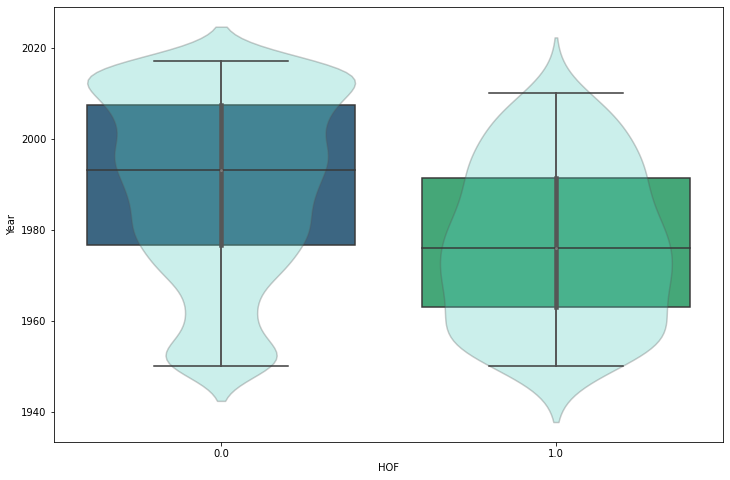

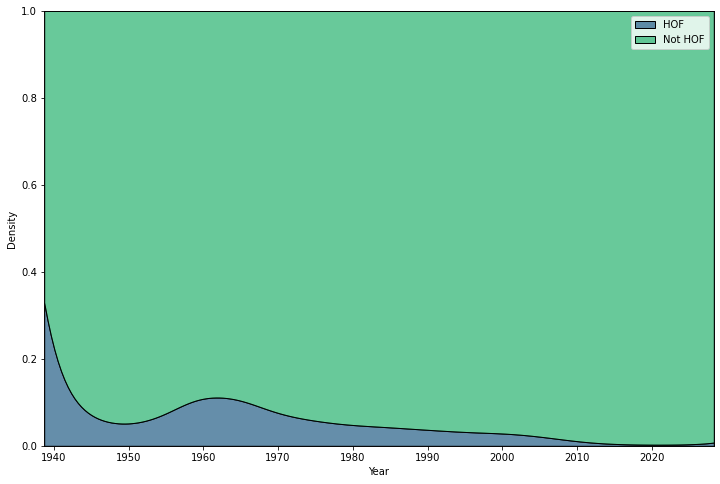

Pearson correlation of G_average to target HOF: 0.2388090854775363


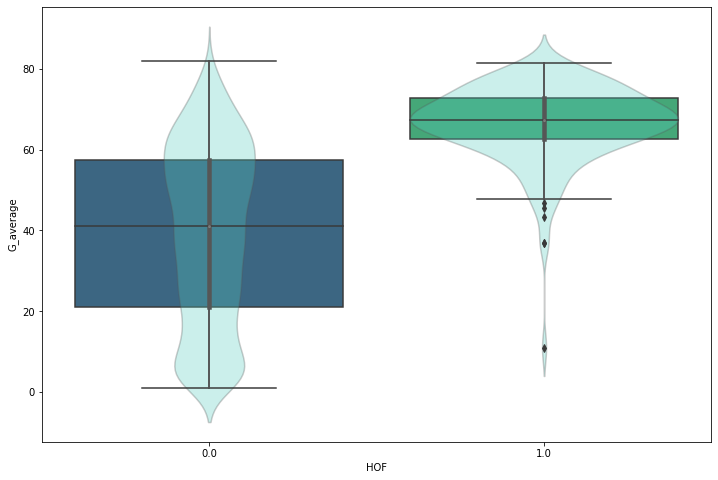

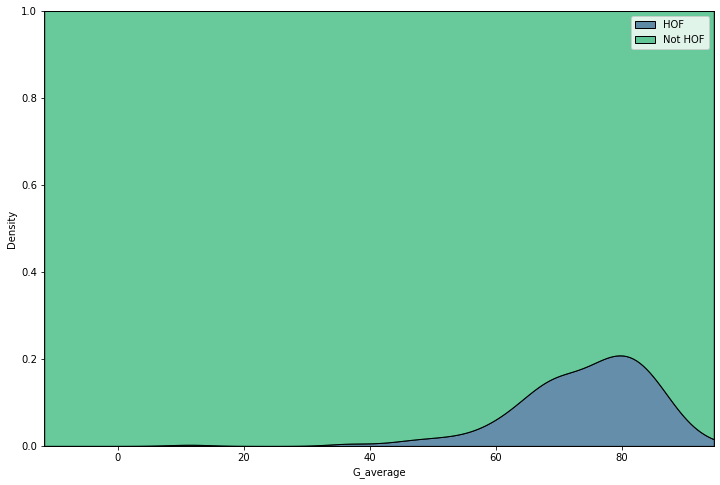

Pearson correlation of GS_average to target HOF: 0.33144229758789856


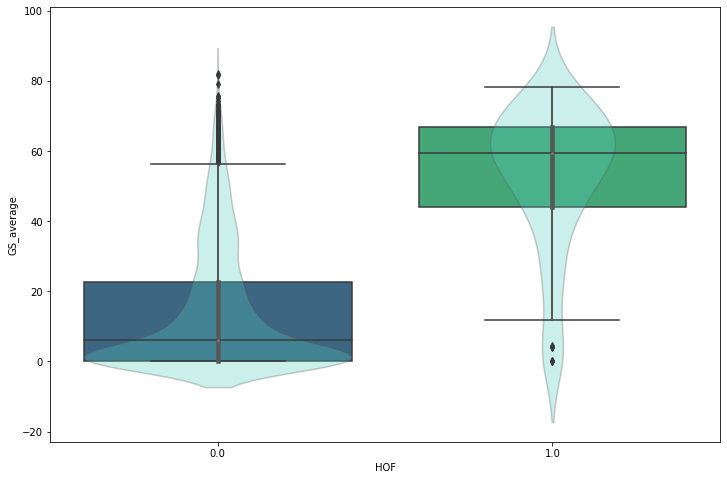

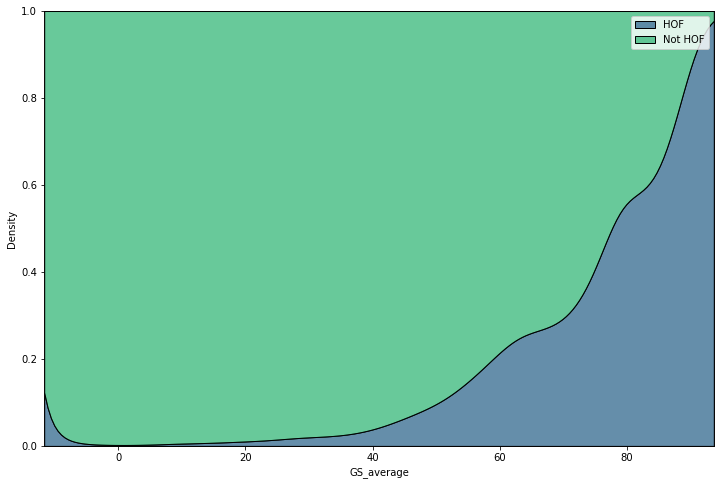

Pearson correlation of MP_average to target HOF: 0.3824616958985679


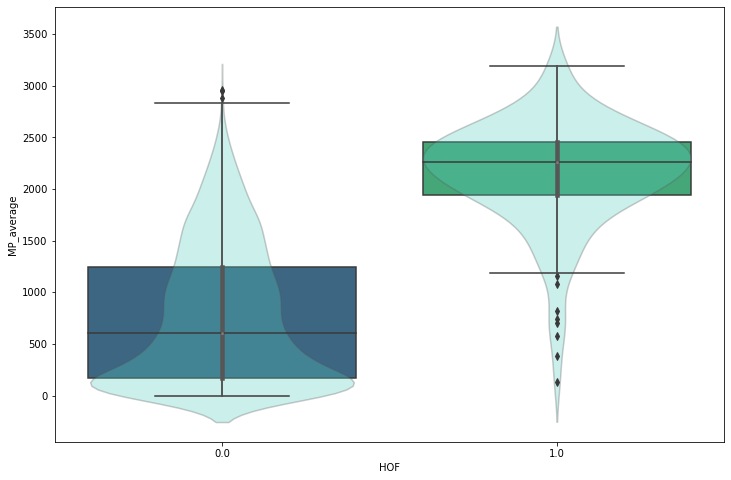

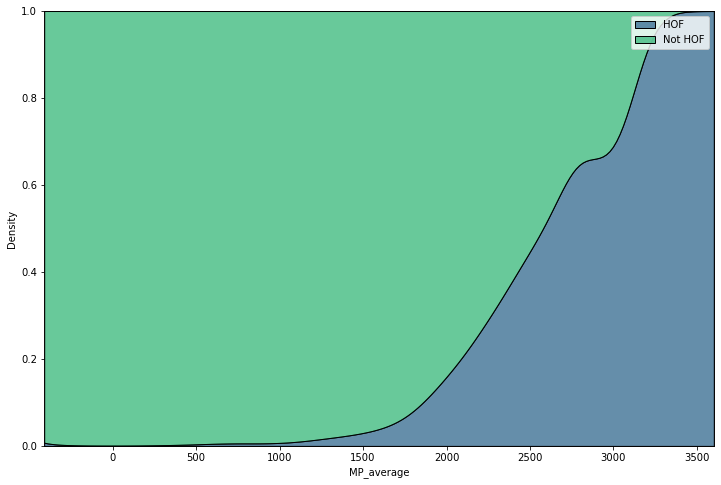

Pearson correlation of PER to target HOF: 0.22178936278723704


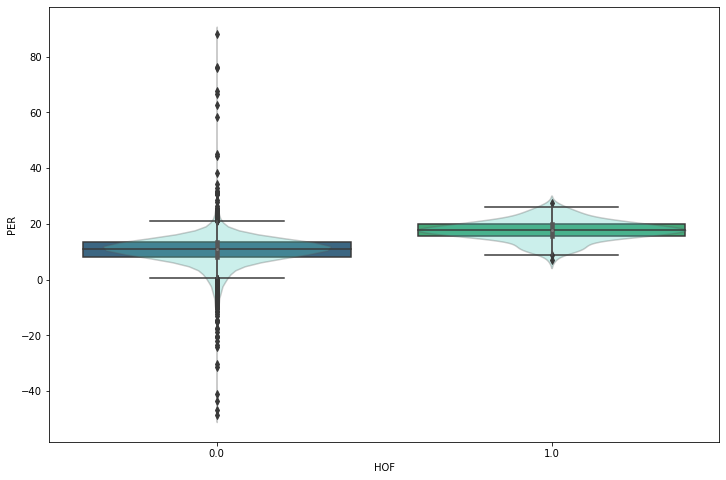

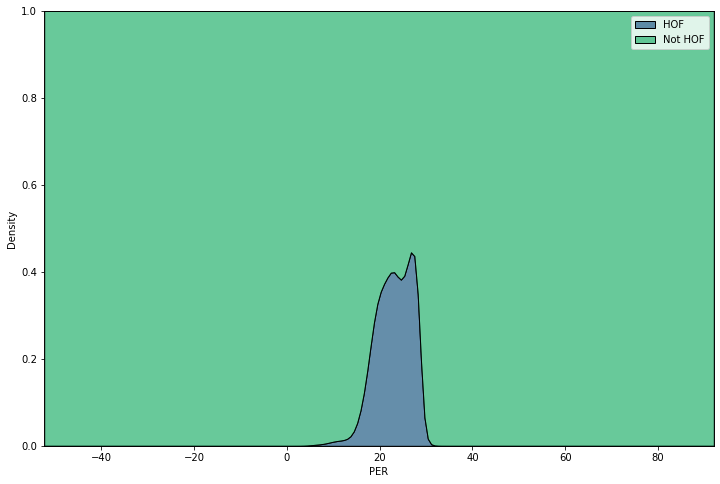

Pearson correlation of TS% to target HOF: 0.1023502614492637


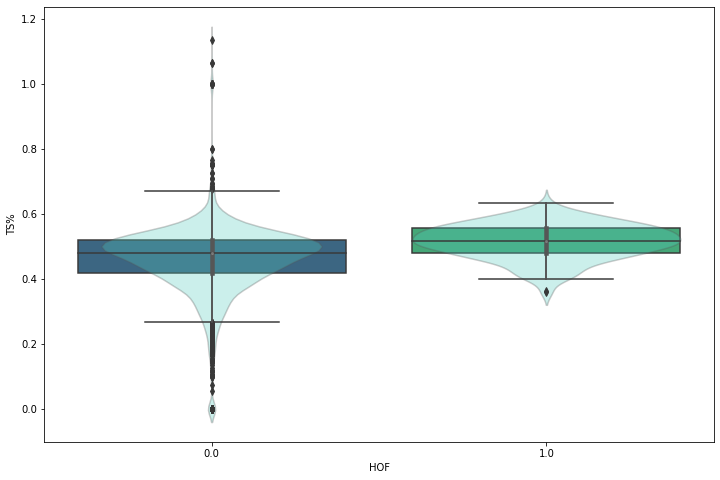

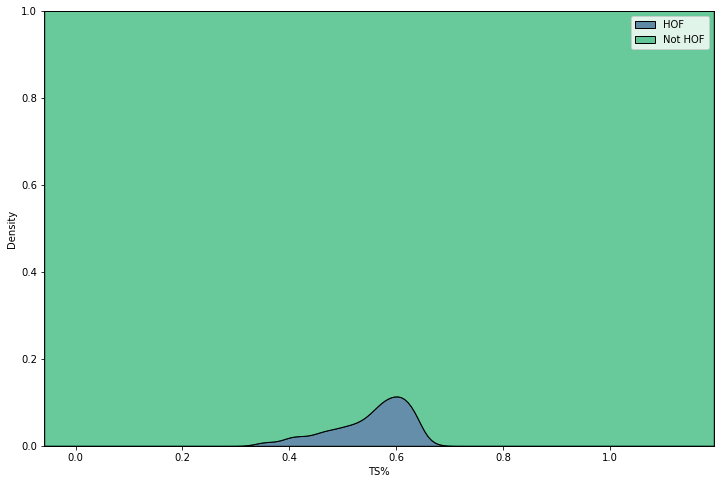

Pearson correlation of 3PAr to target HOF: -0.07274220349115605


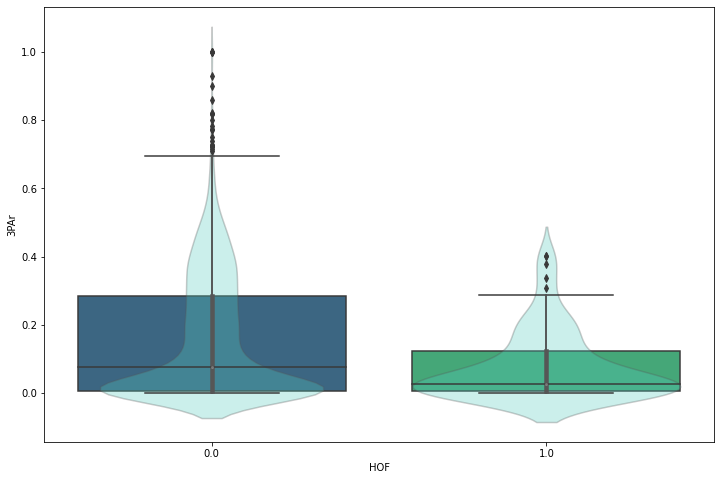

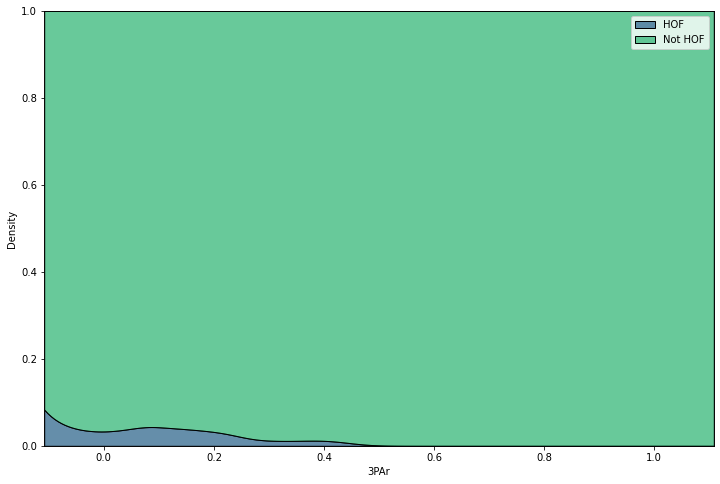

Pearson correlation of FTr to target HOF: 0.05289153593669834


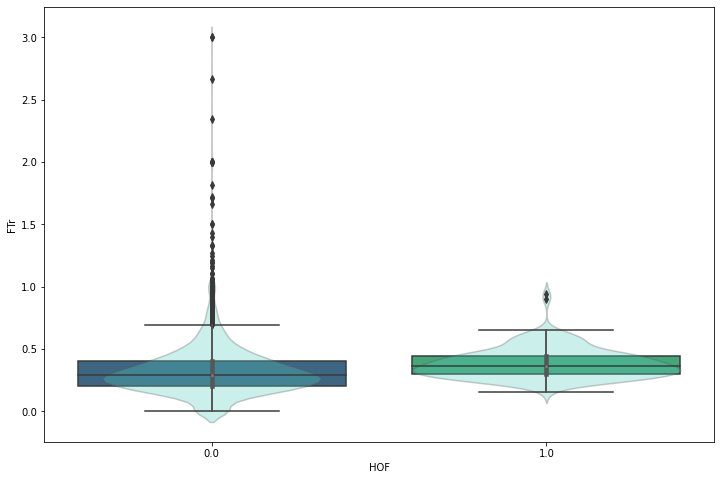

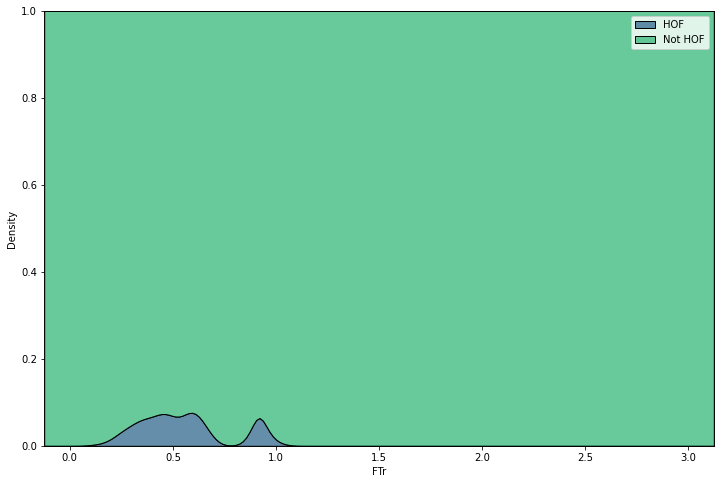

Pearson correlation of ORB% to target HOF: -0.008906542101096761


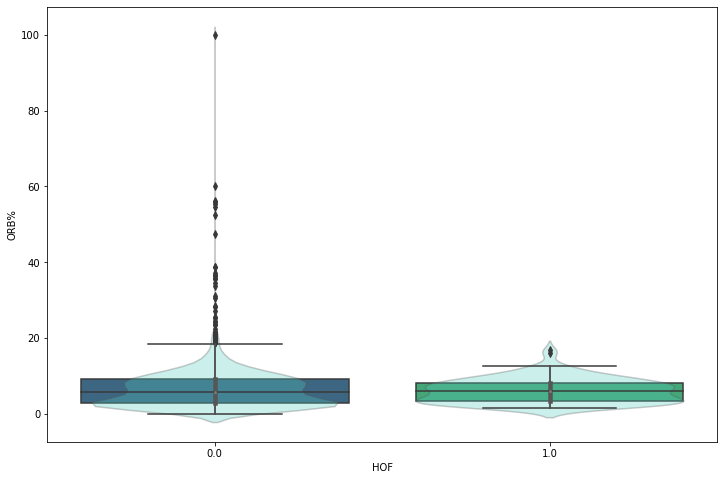

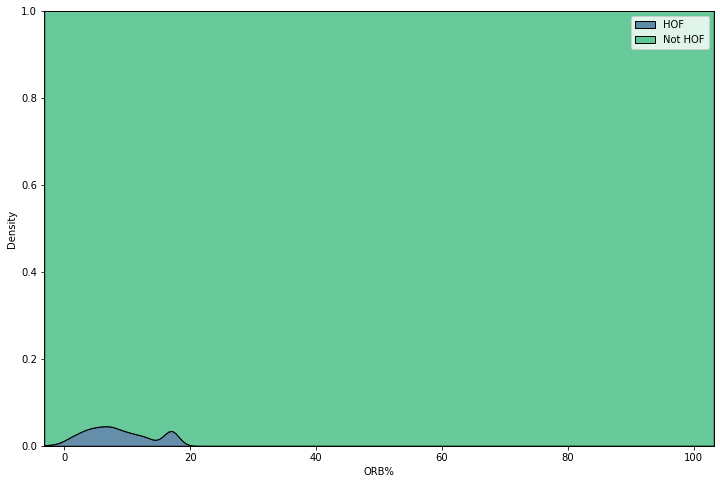

Pearson correlation of DRB% to target HOF: 0.06372623278174279


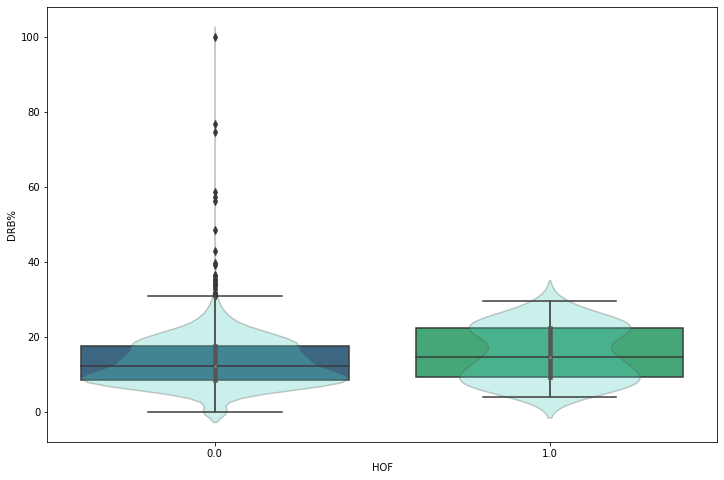

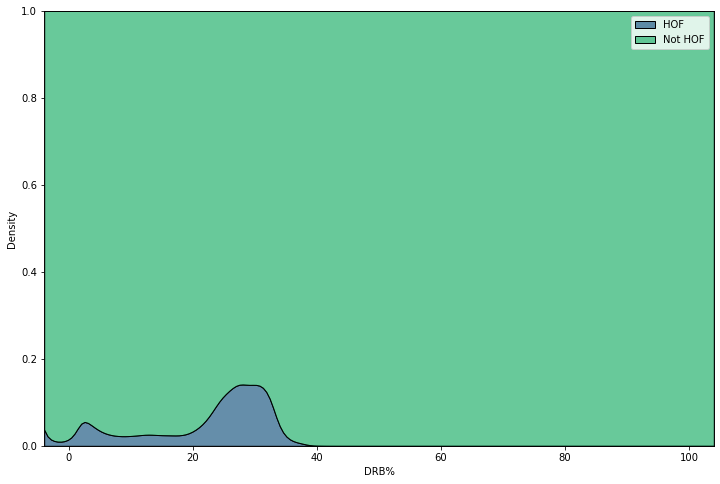

Pearson correlation of TRB% to target HOF: 0.04347091383626531


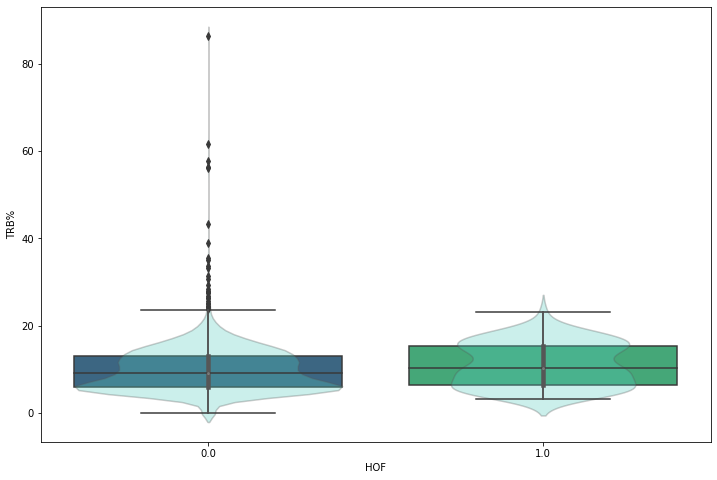

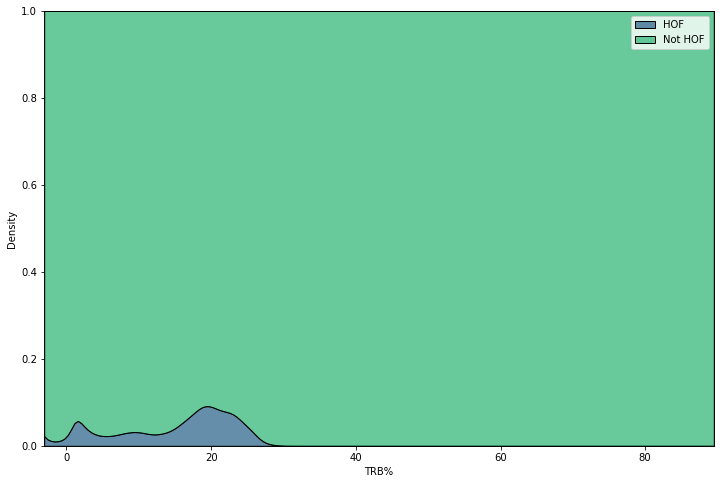

Pearson correlation of AST% to target HOF: 0.107283374630196


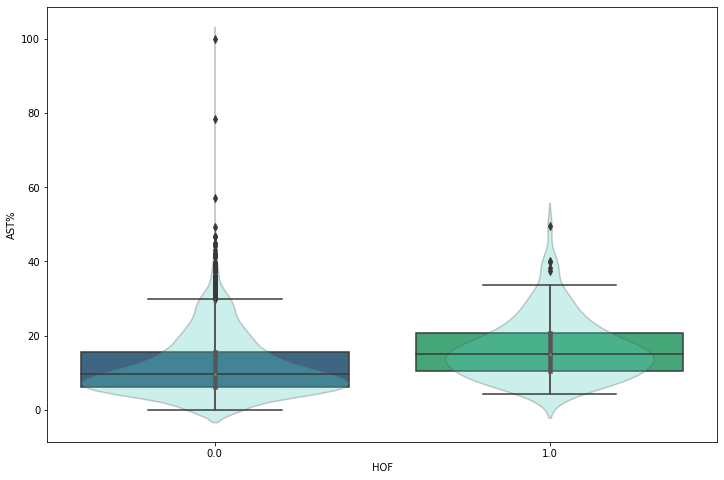

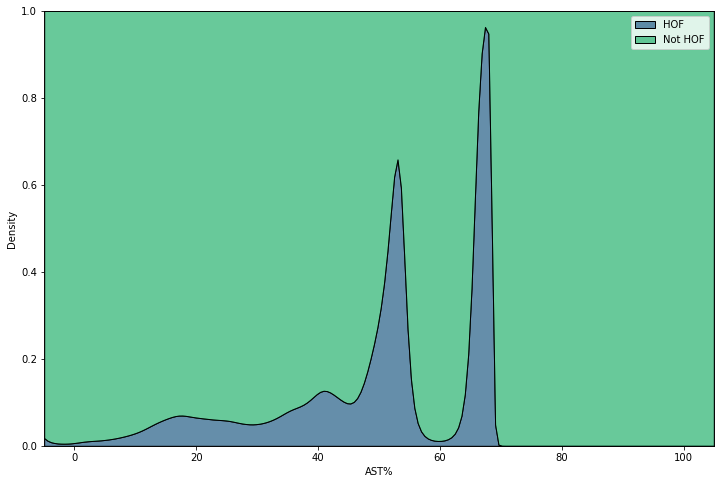

Pearson correlation of STL% to target HOF: 0.013405725715434214


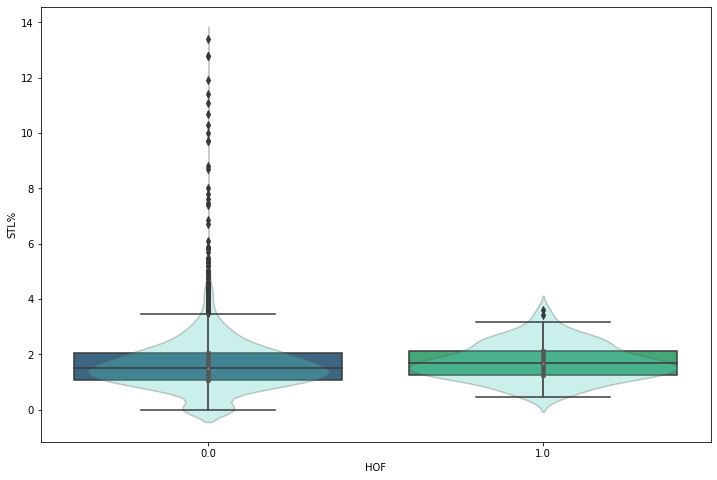

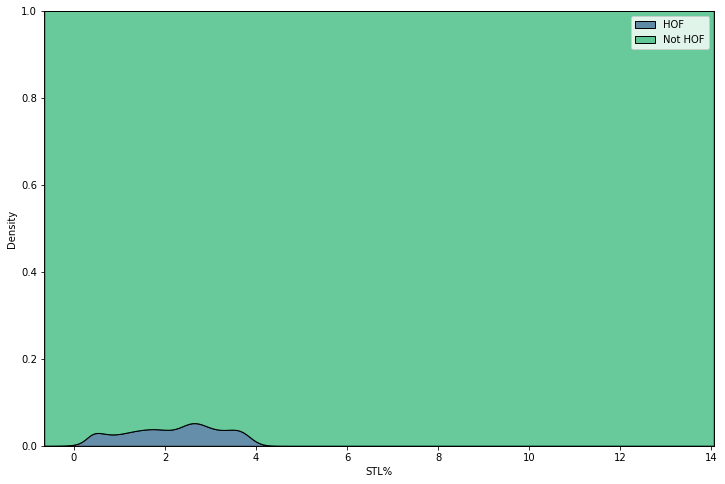

Pearson correlation of BLK% to target HOF: 0.0391338926512763


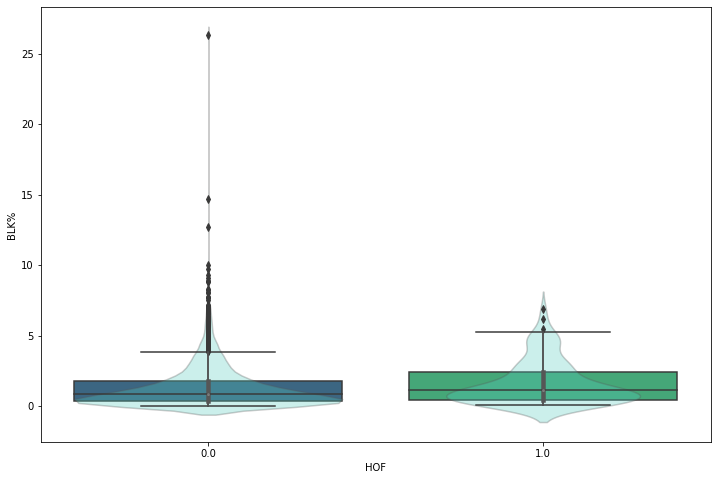

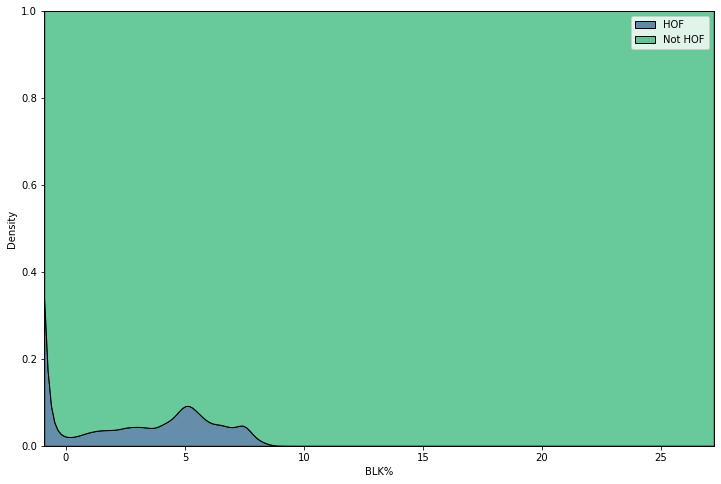

Pearson correlation of TOV% to target HOF: -0.030226516506916507


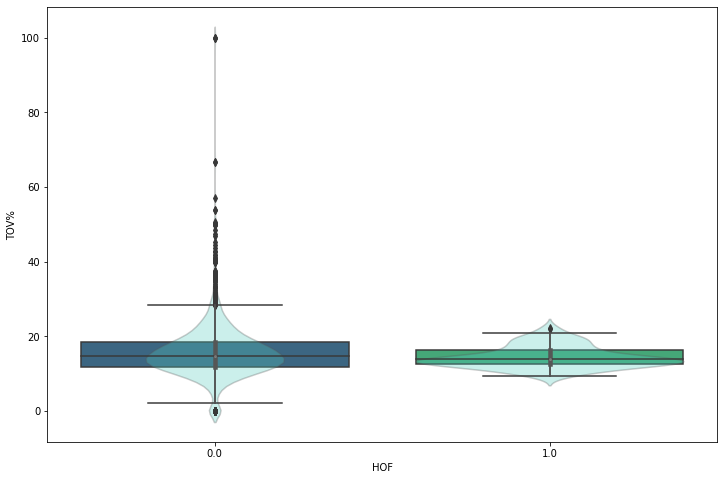

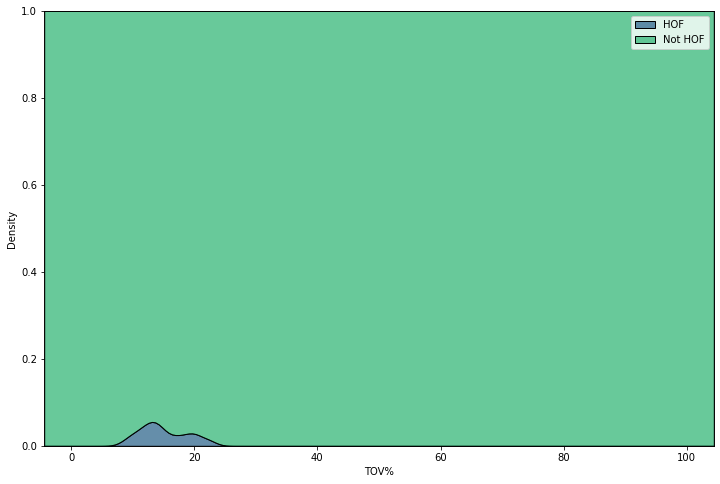

Pearson correlation of USG% to target HOF: 0.13607318084235748


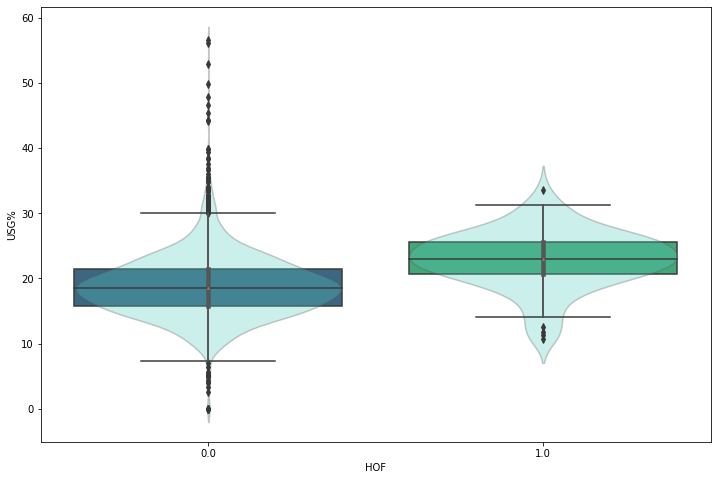

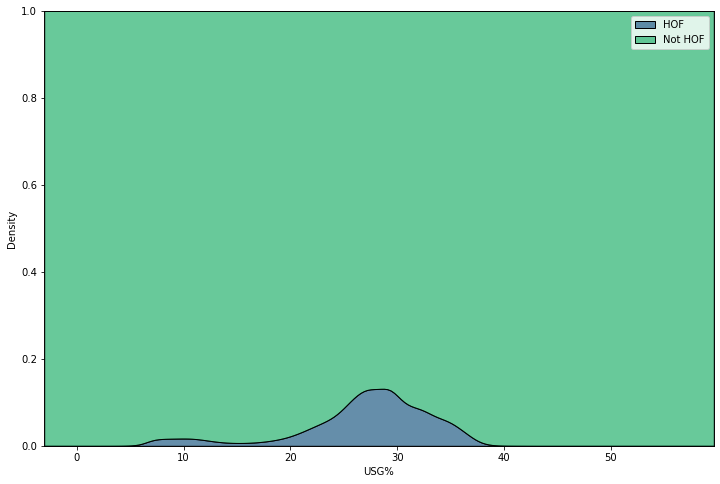

Pearson correlation of OWS_average to target HOF: 0.470859392001751


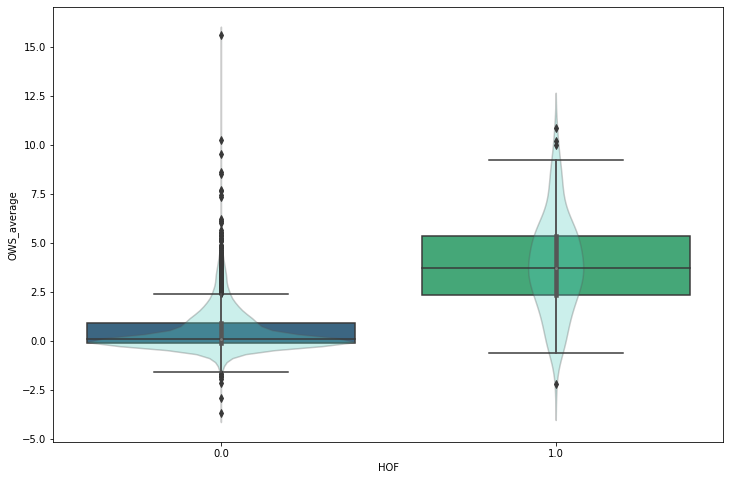

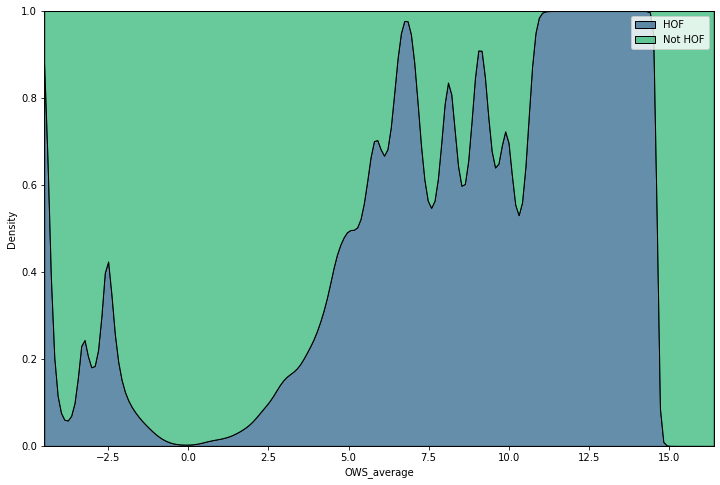

Pearson correlation of DWS_average to target HOF: 0.45169524750363693


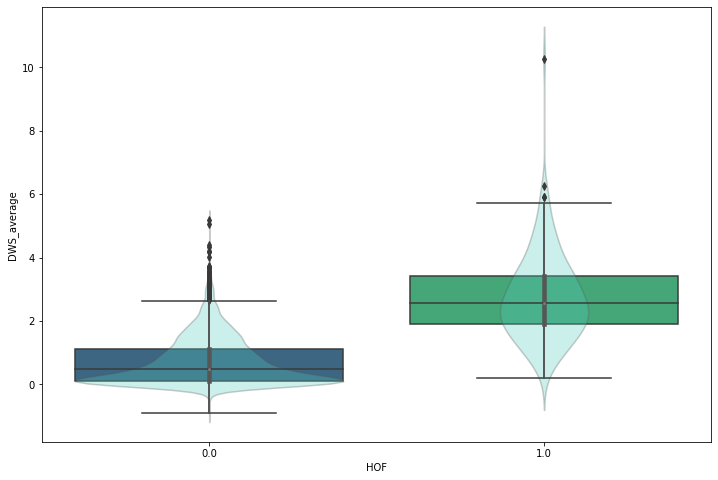

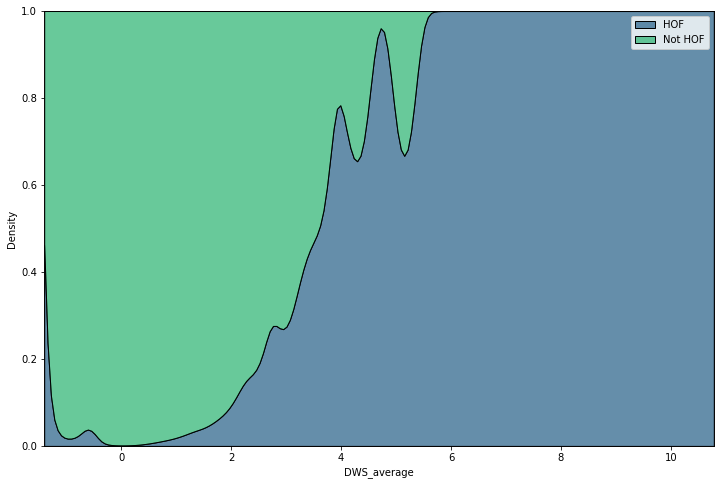

Pearson correlation of WS_average to target HOF: 0.5070855084454169


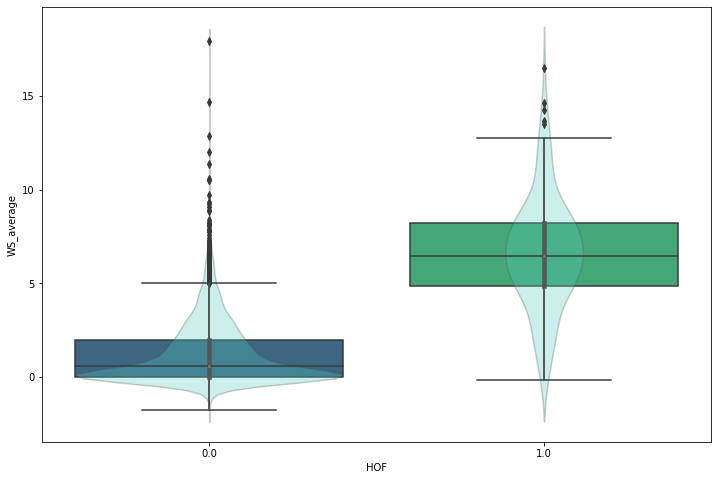

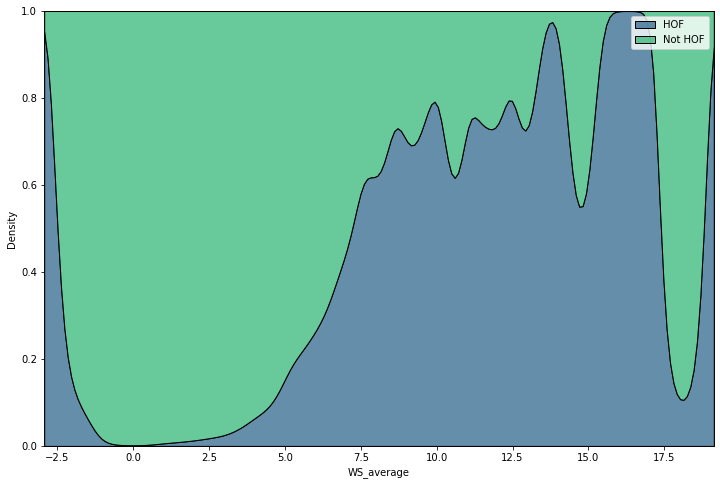

Pearson correlation of WS/48 to target HOF: 0.1722353409765193


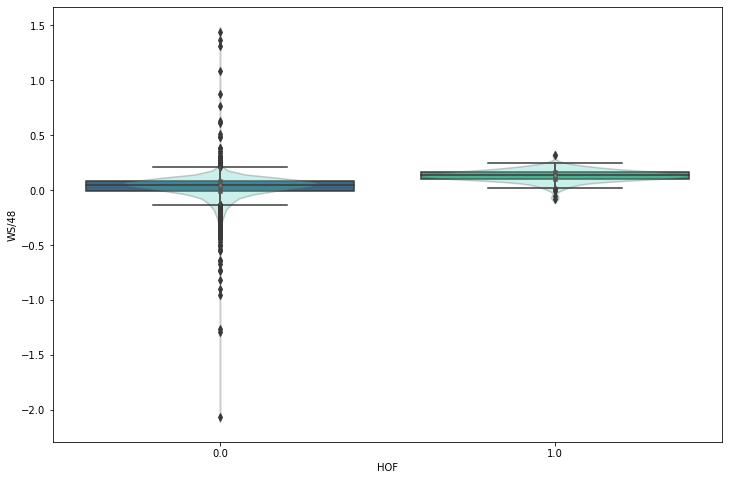

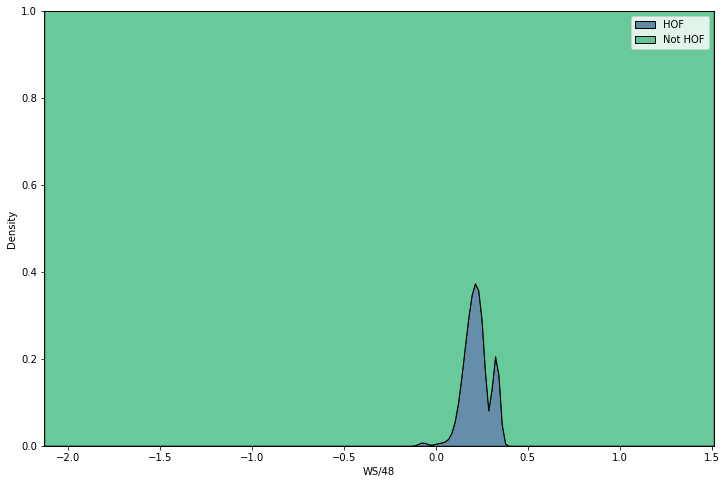

Pearson correlation of OBPM to target HOF: 0.1940335365682578


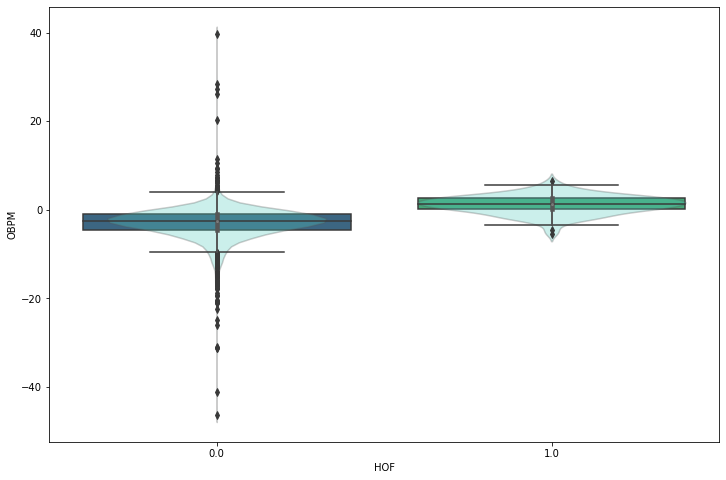

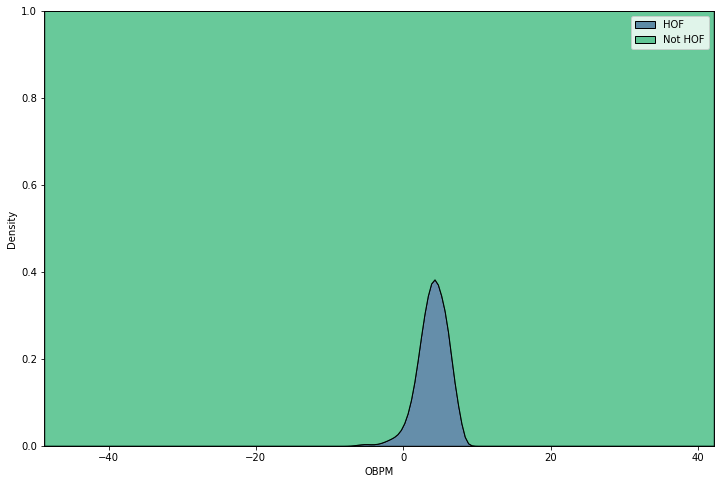

Pearson correlation of DBPM to target HOF: 0.11979357796965616


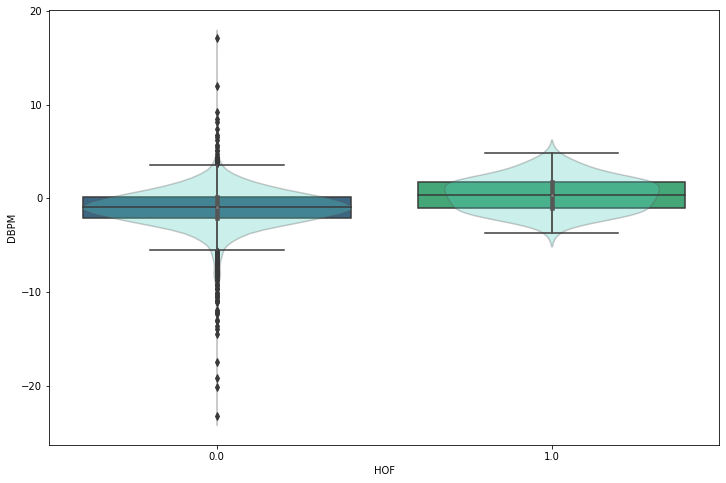

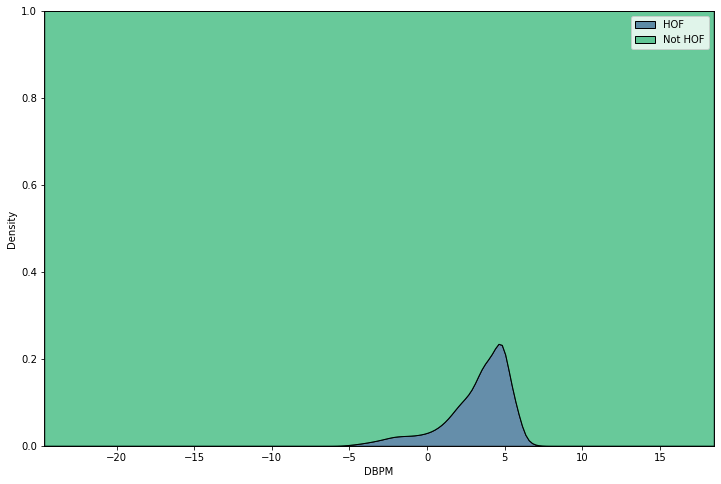

Pearson correlation of BPM to target HOF: 0.21032664343509486


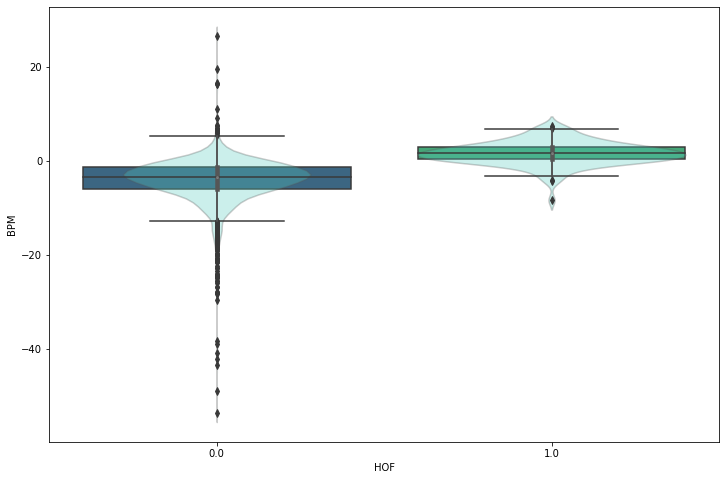

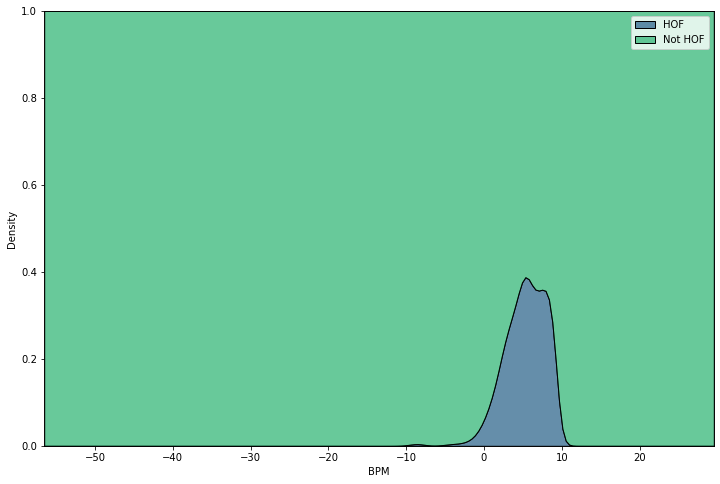

Pearson correlation of VORP_average to target HOF: 0.46892786860325264


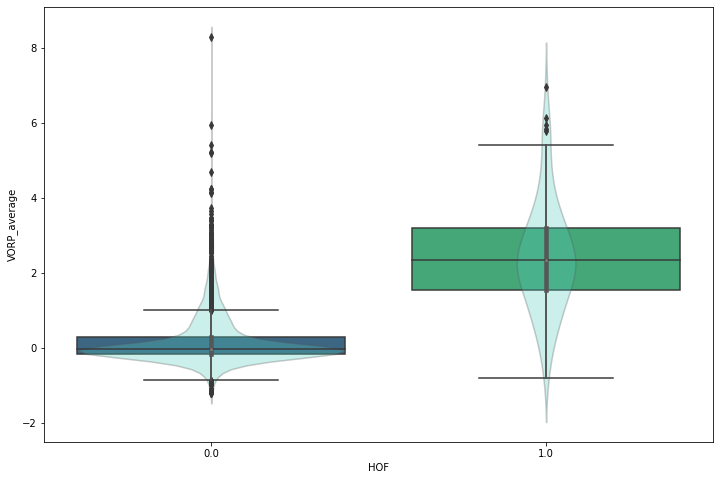

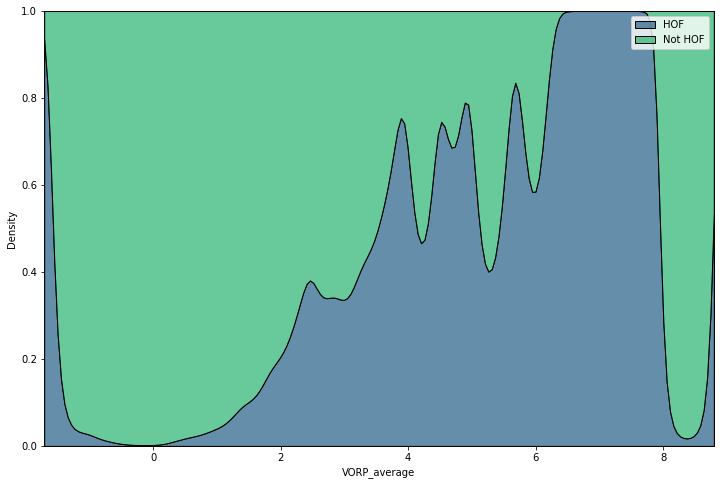

Pearson correlation of FG_average to target HOF: 0.44799143795647284


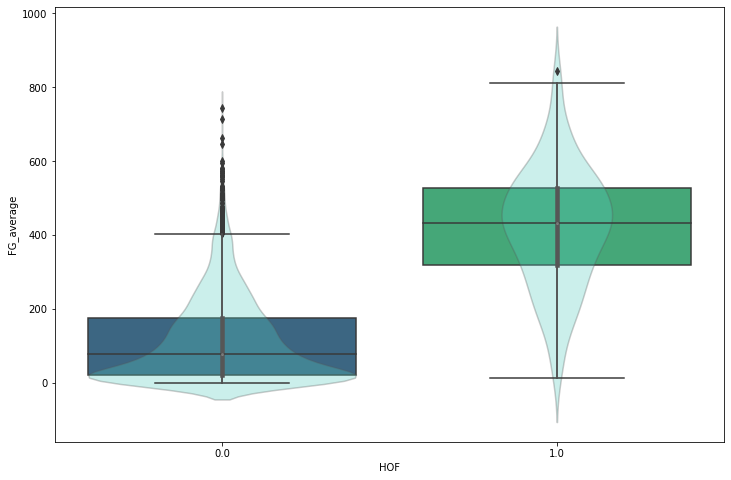

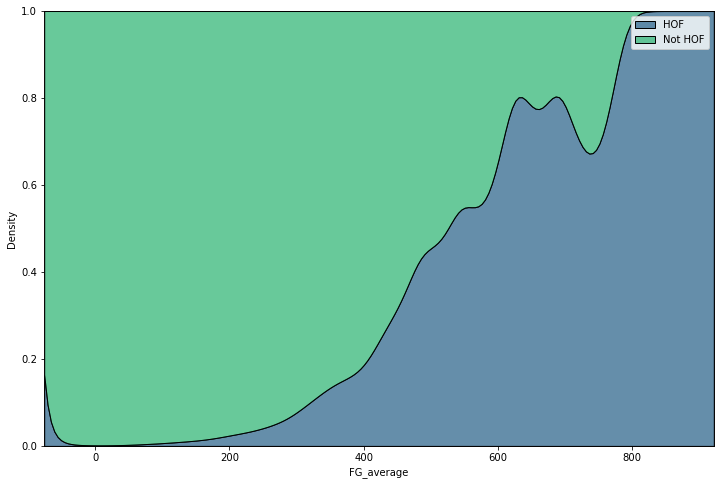

Pearson correlation of FGA_average to target HOF: 0.44089639465468633


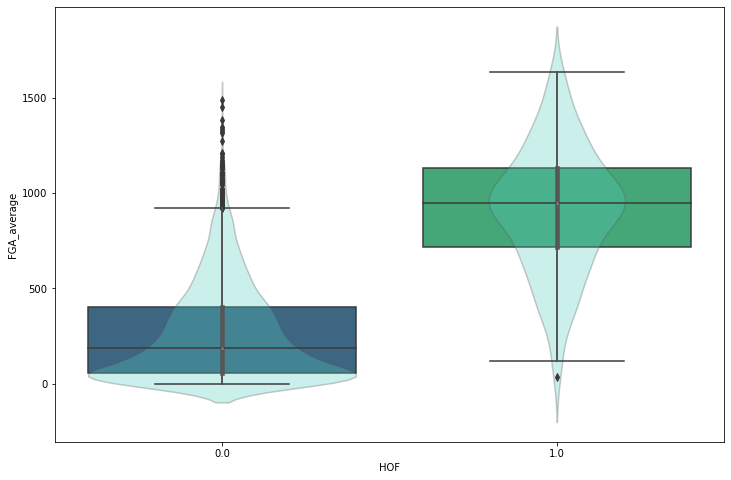

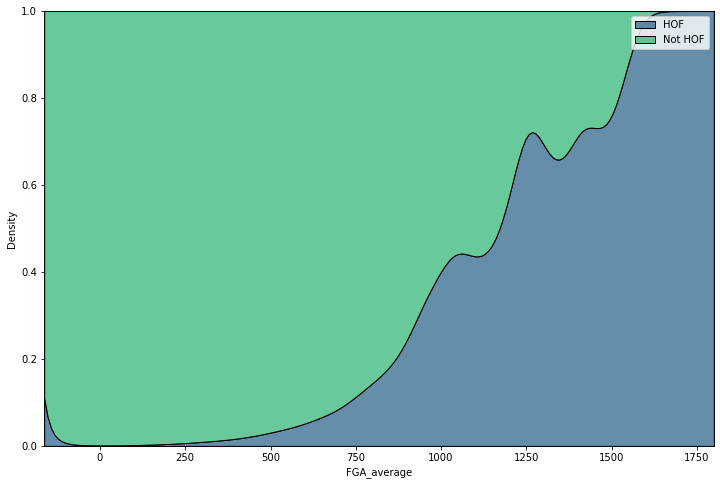

Pearson correlation of FG% to target HOF: 0.0933624165651608


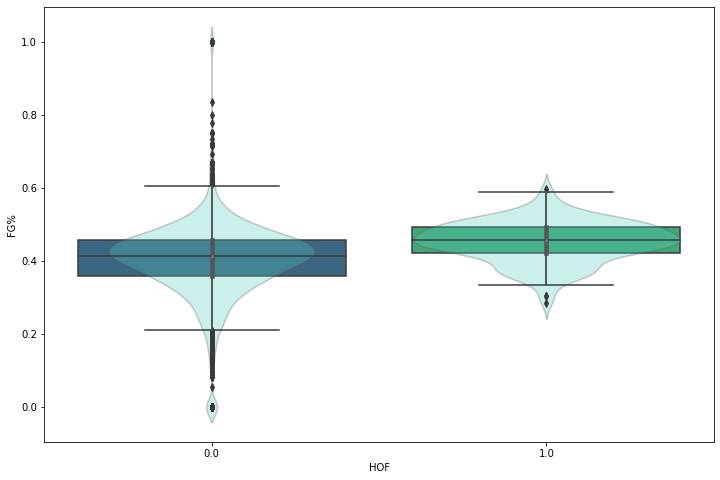

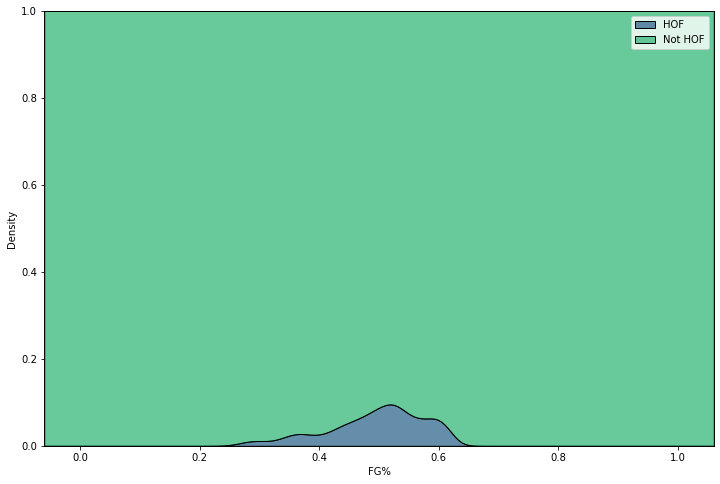

Pearson correlation of 3P_average to target HOF: 0.0522794857249326


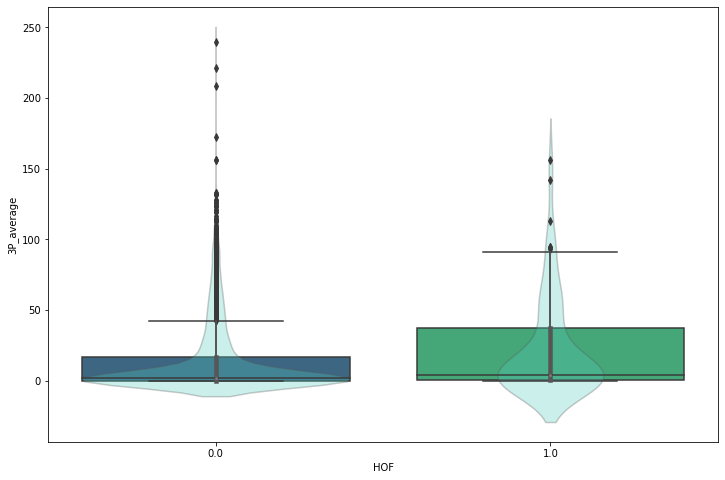

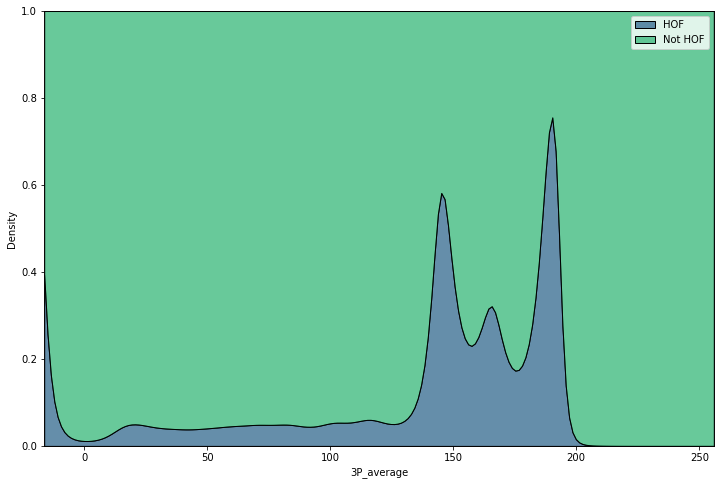

Pearson correlation of 3PA_average to target HOF: 0.056513819308726024


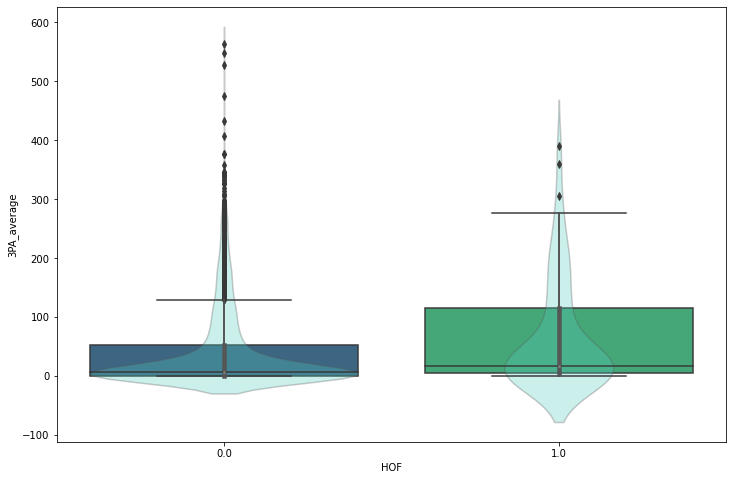

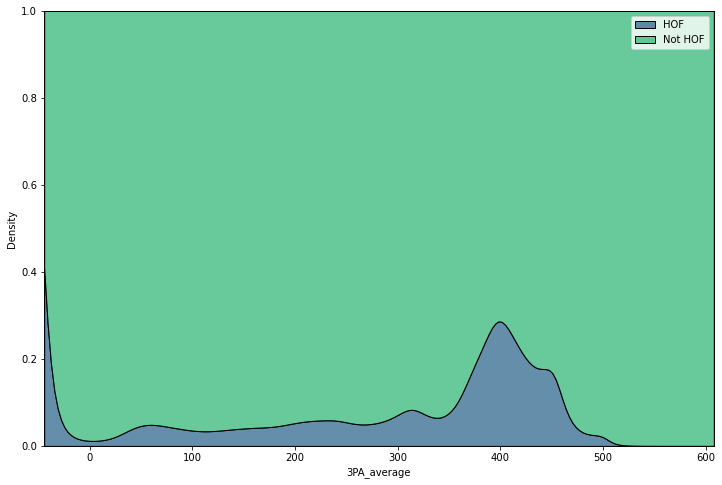

Pearson correlation of 3P% to target HOF: -0.007645118390695112


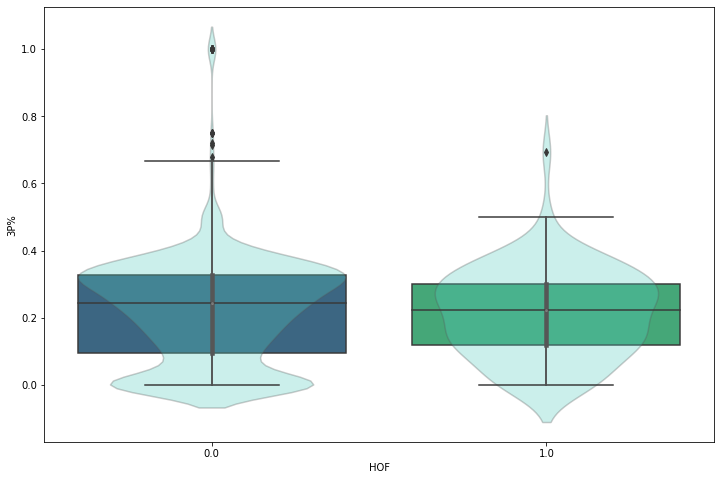

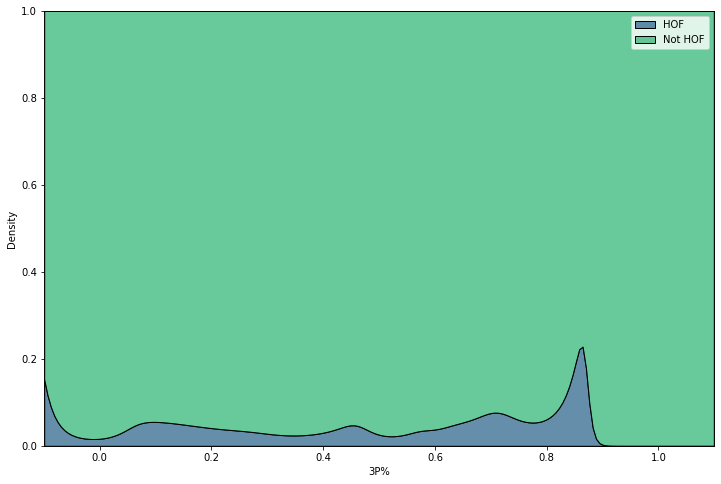

Pearson correlation of 2P_average to target HOF: 0.47353104450798944


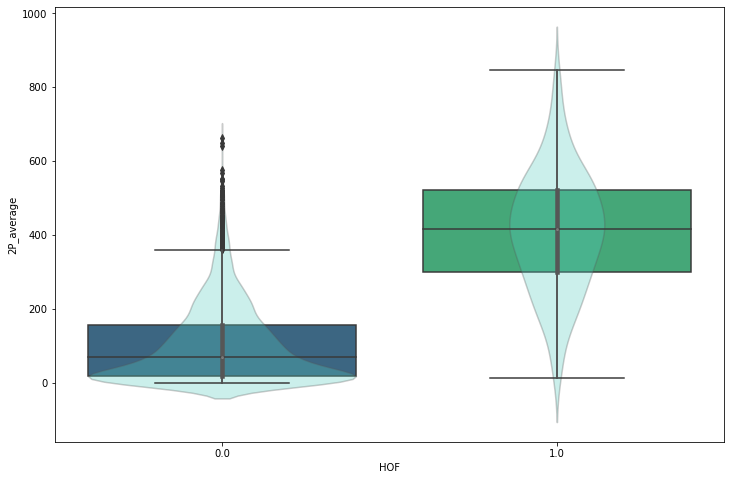

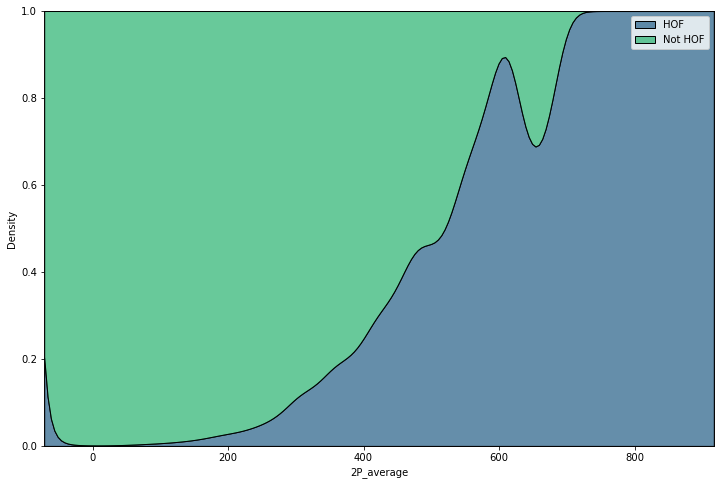

Pearson correlation of 2PA_average to target HOF: 0.4751686197078645


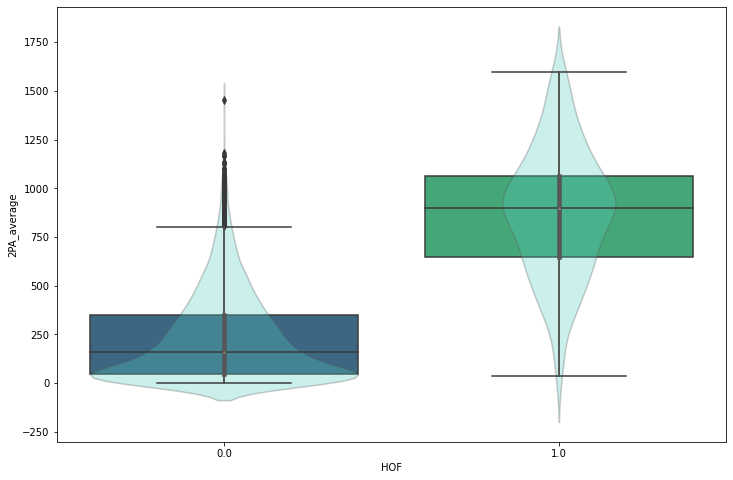

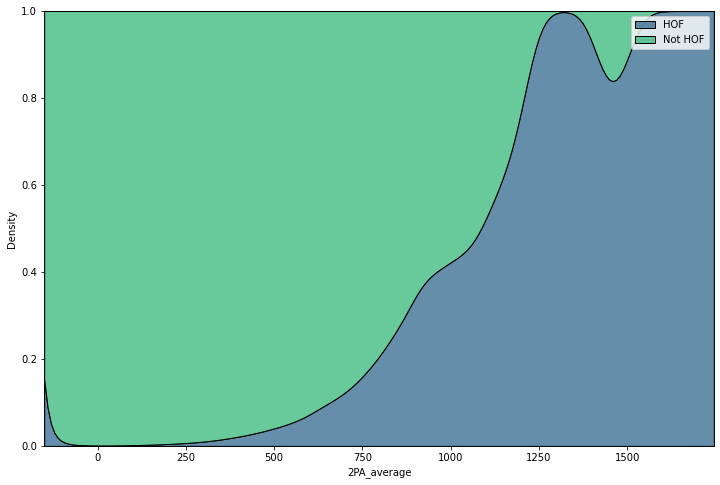

Pearson correlation of 2P% to target HOF: 0.07254091231048514


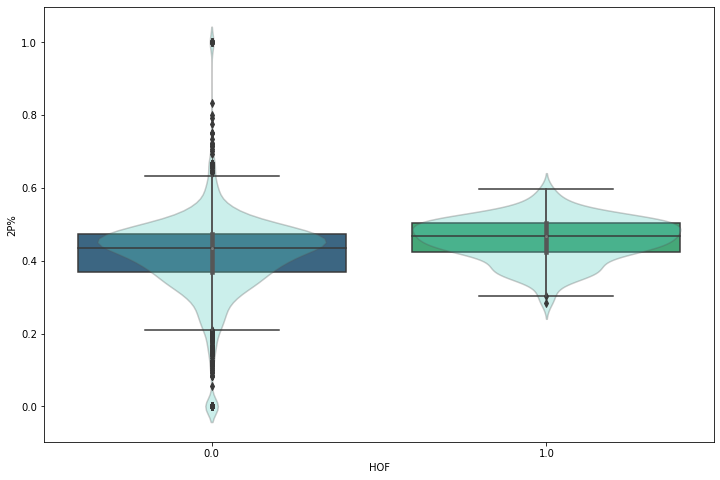

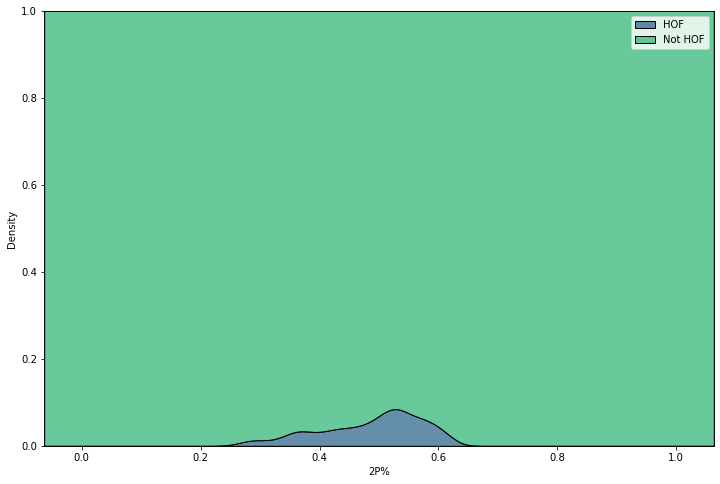

Pearson correlation of eFG% to target HOF: 0.0703842262520768


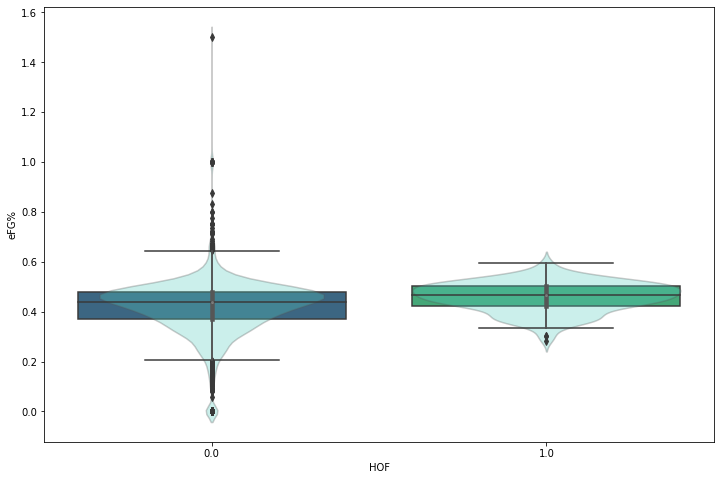

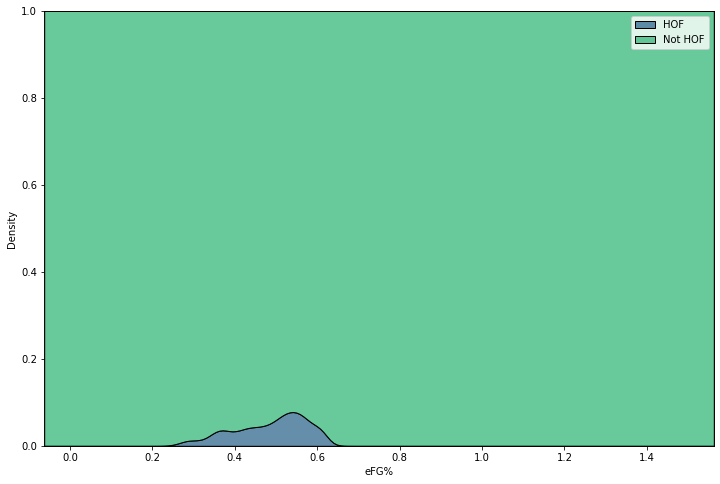

Pearson correlation of FT_average to target HOF: 0.505252359869385


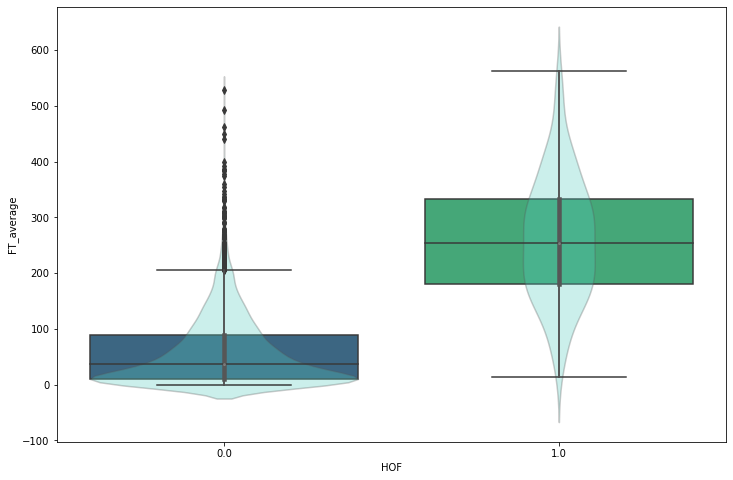

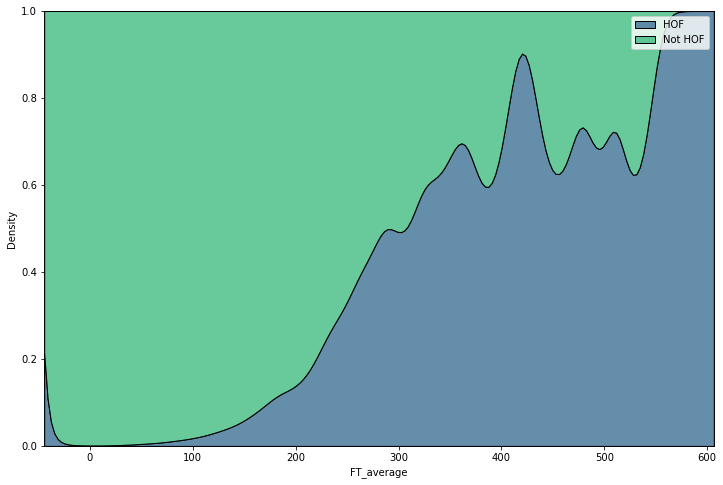

Pearson correlation of FTA_average to target HOF: 0.5053870797348392


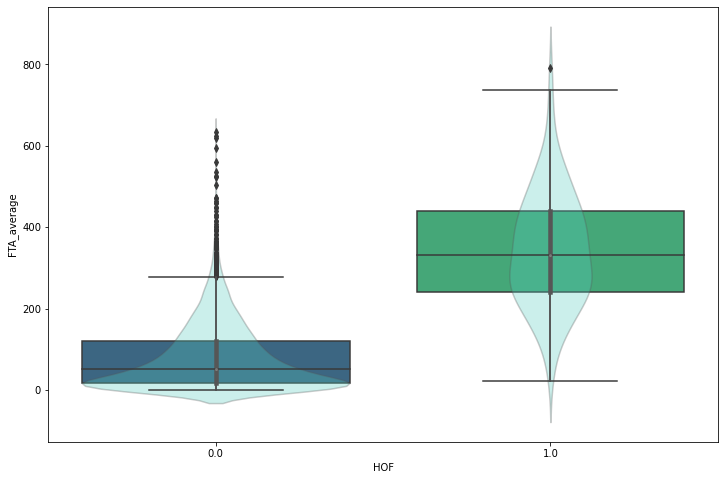

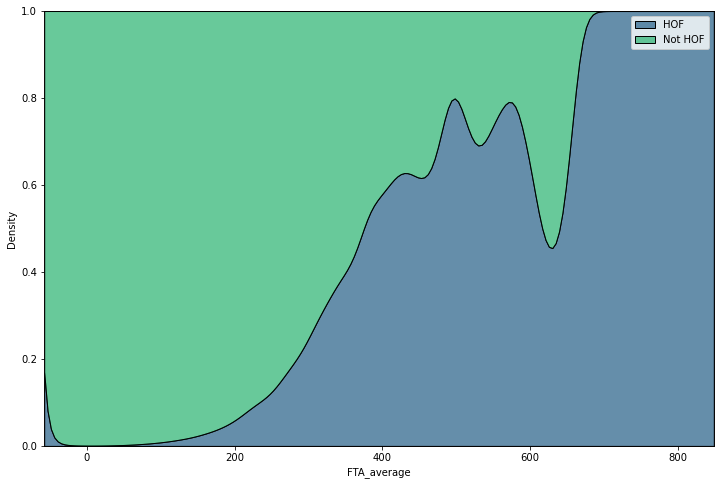

Pearson correlation of FT% to target HOF: 0.08413761729578198


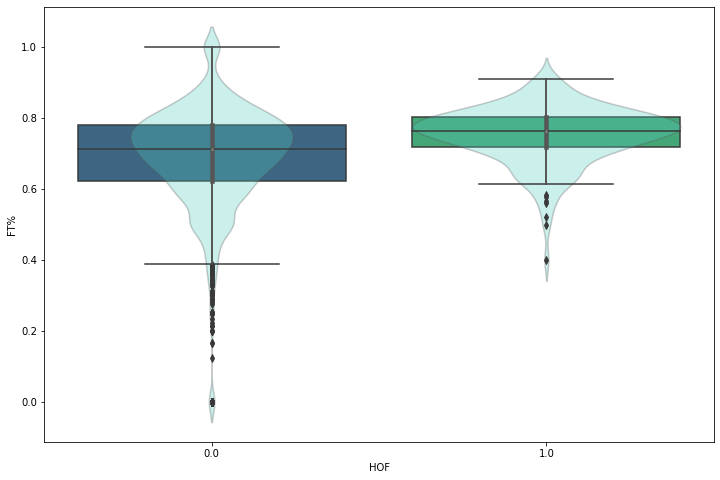

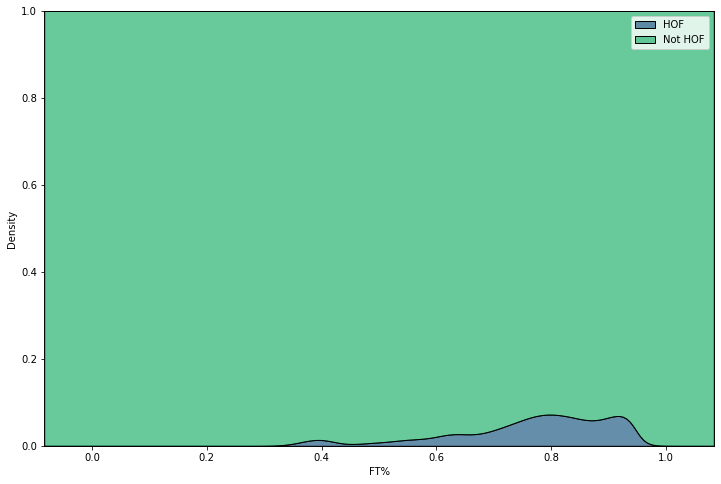

Pearson correlation of ORB_average to target HOF: 0.2922466781418919


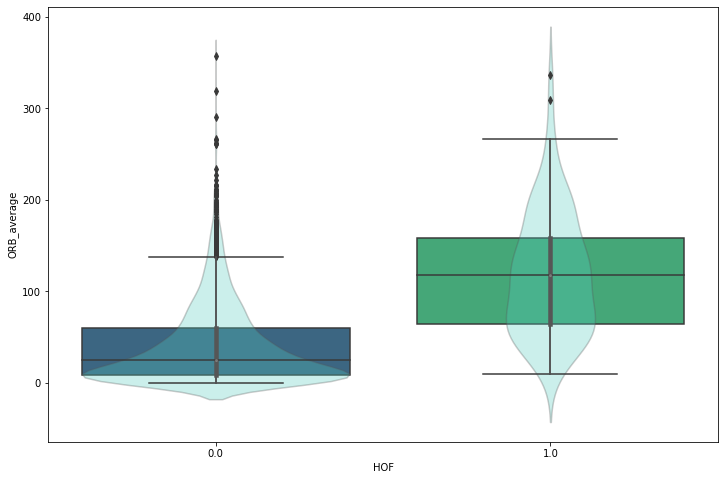

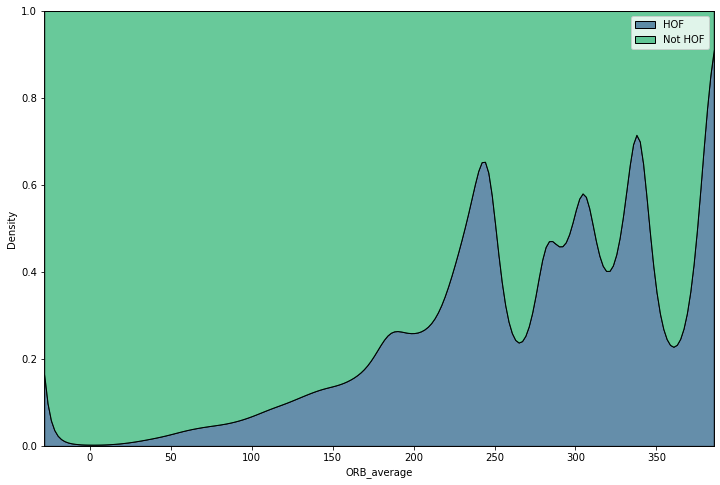

Pearson correlation of DRB_average to target HOF: 0.35123263520528775


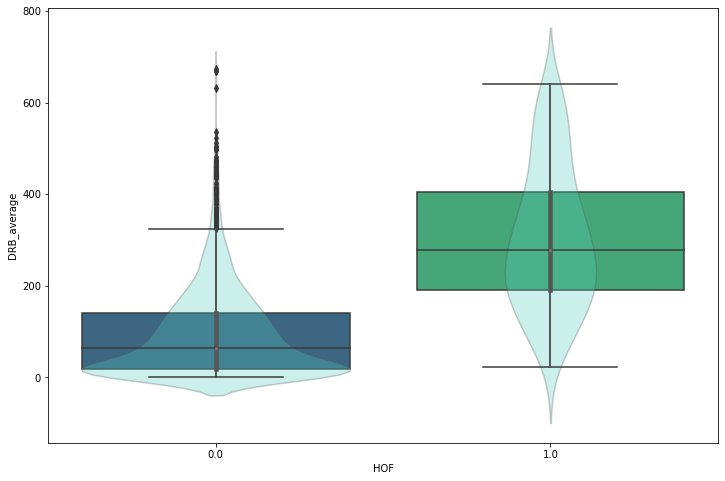

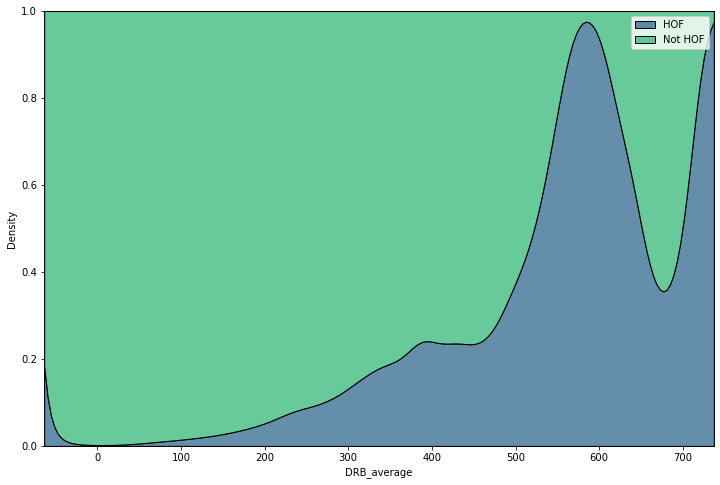

Pearson correlation of TRB_average to target HOF: 0.4203253910879831


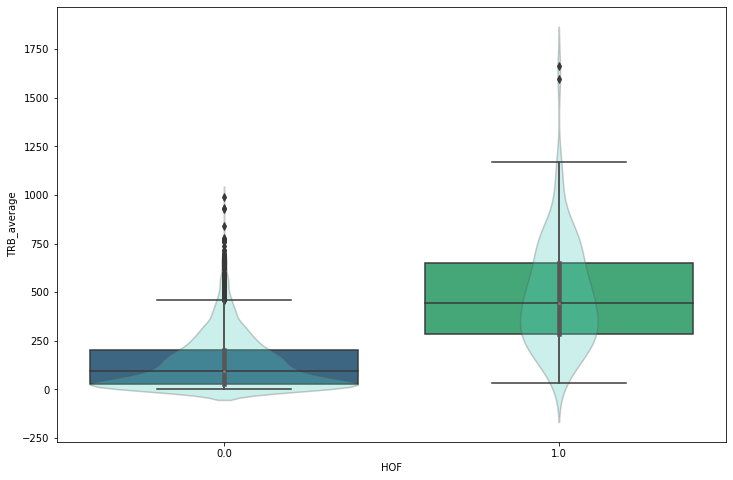

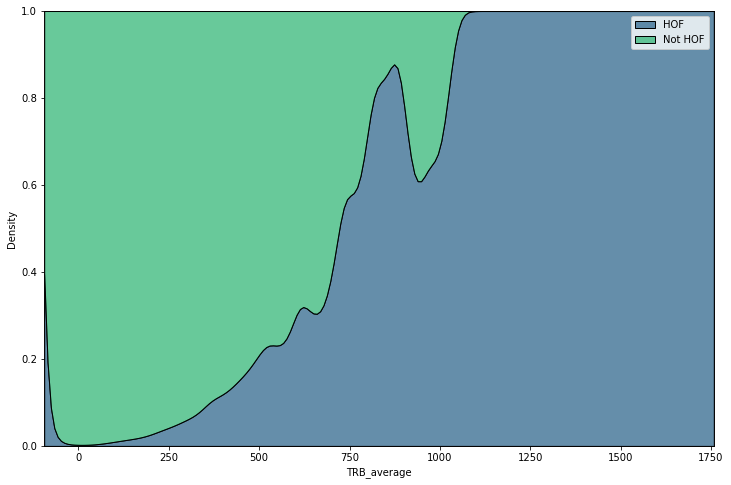

Pearson correlation of AST_average to target HOF: 0.3486863572488893


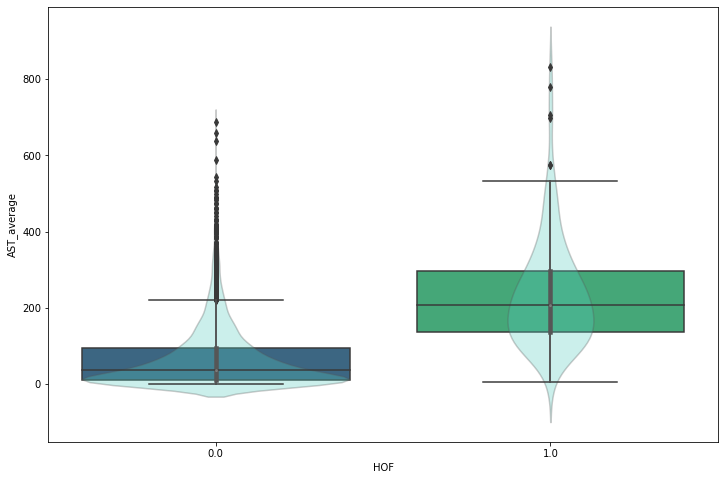

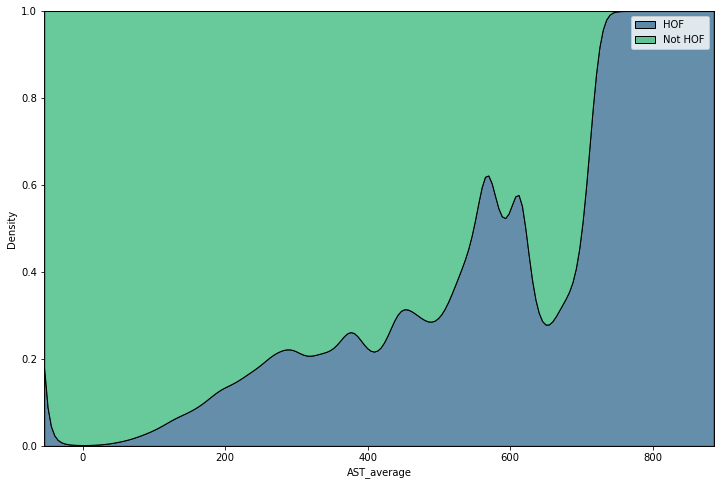

Pearson correlation of STL_average to target HOF: 0.319931368197405


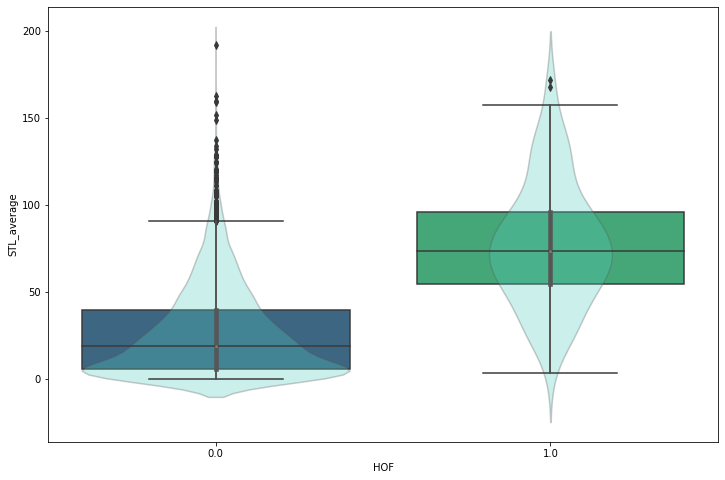

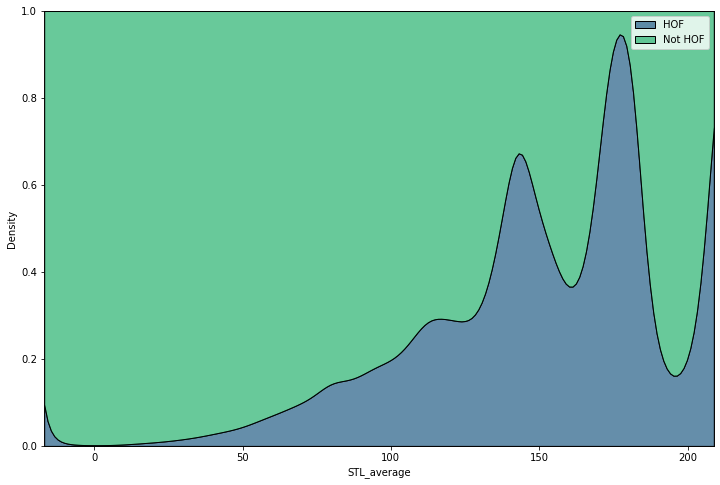

Pearson correlation of BLK_average to target HOF: 0.2871162586812915


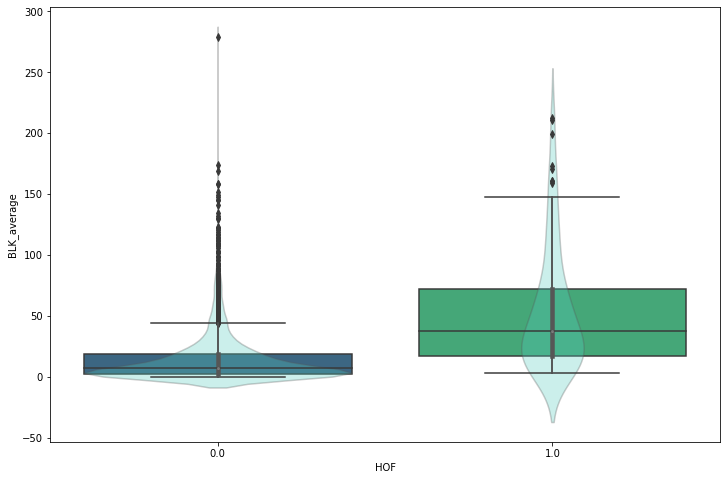

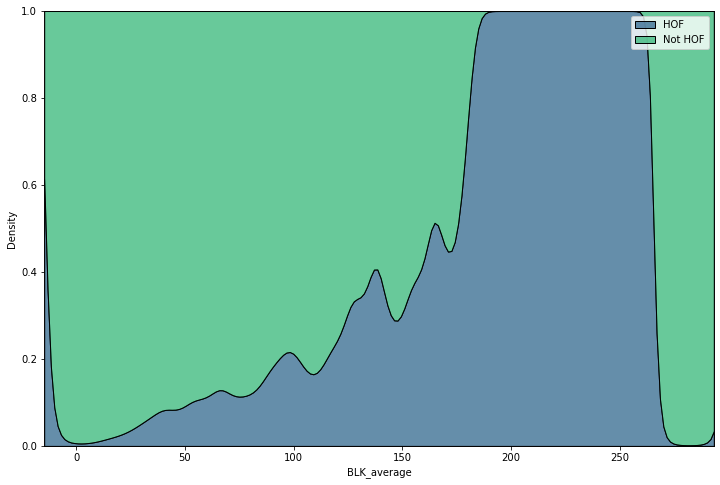

Pearson correlation of TOV_average to target HOF: 0.3829466454490093


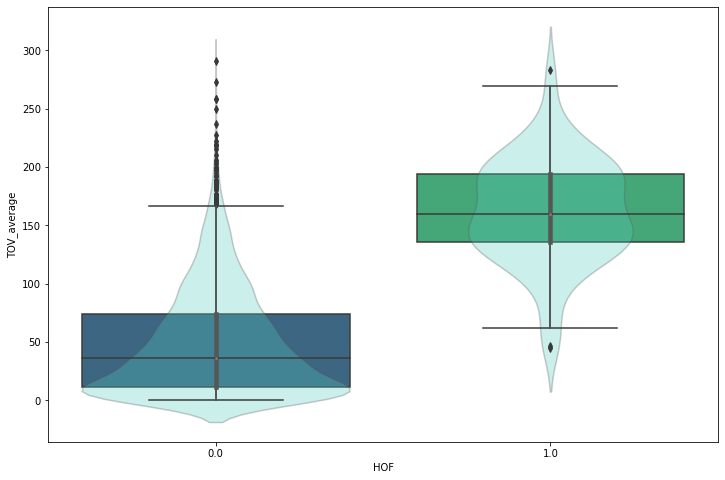

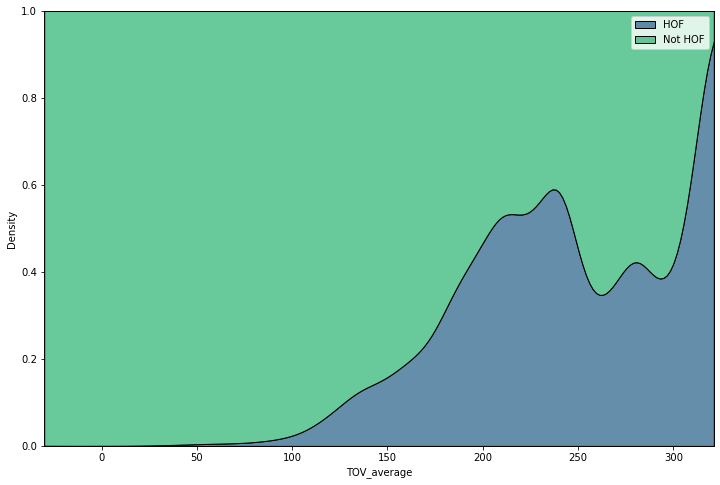

Pearson correlation of PF_average to target HOF: 0.32637940198134613


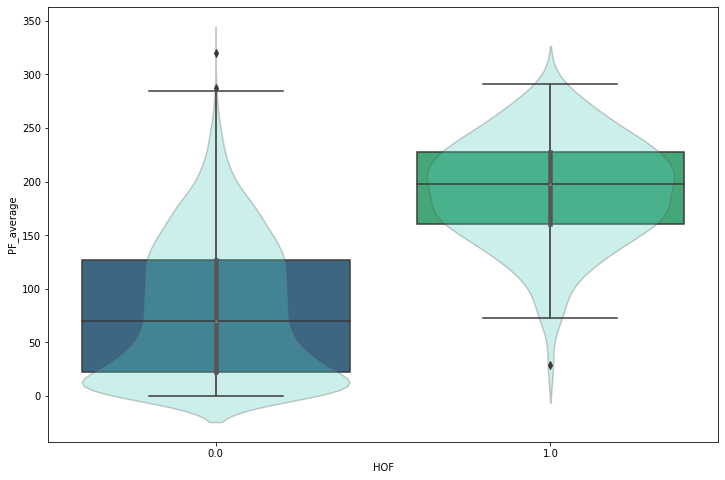

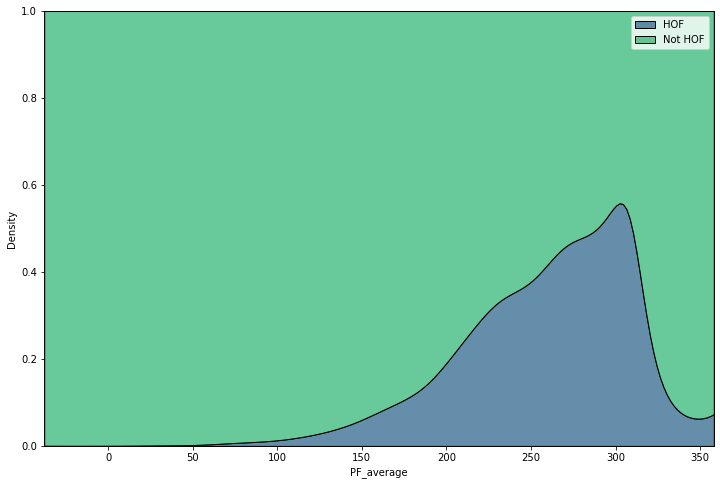

Pearson correlation of PTS_average to target HOF: 0.45550114881412096


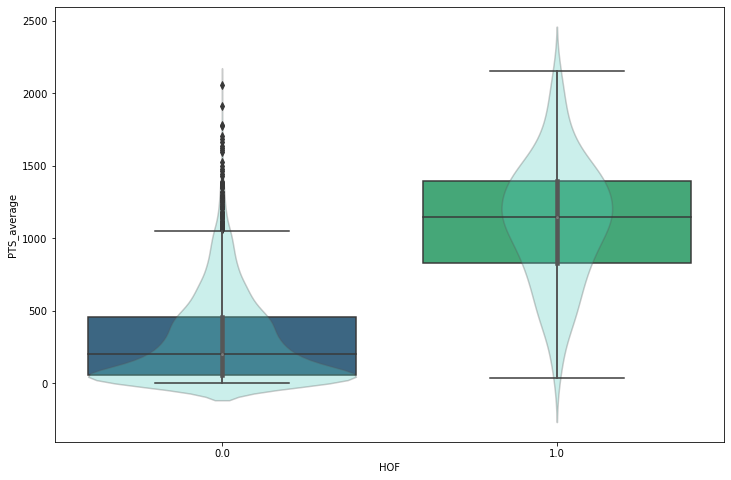

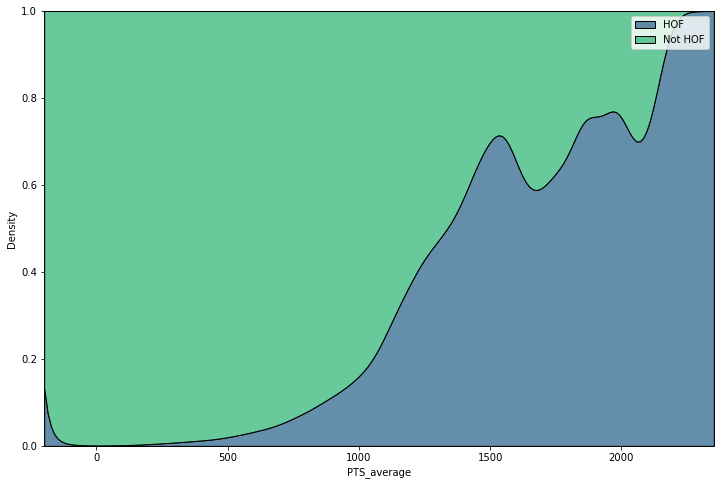

Pearson correlation of WOR_Year_average to target HOF: 0.3317343626814356


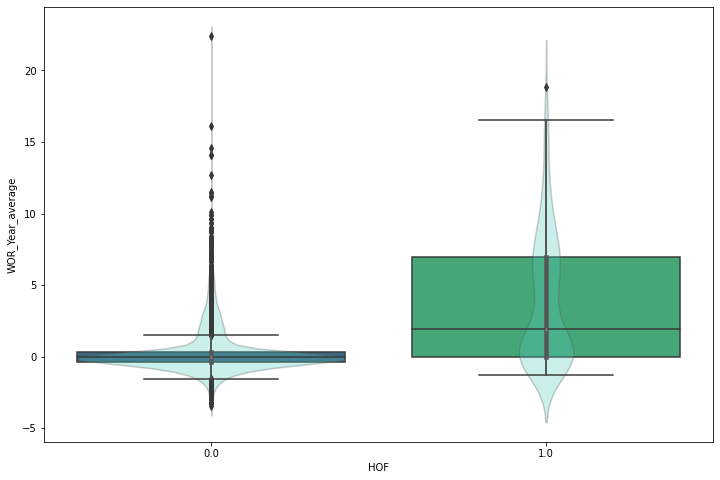

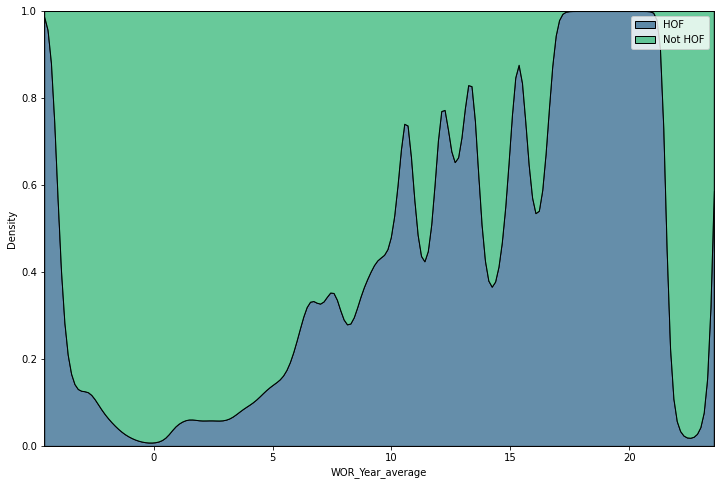

Pearson correlation of years_in_league to target HOF: 0.26434793576997834


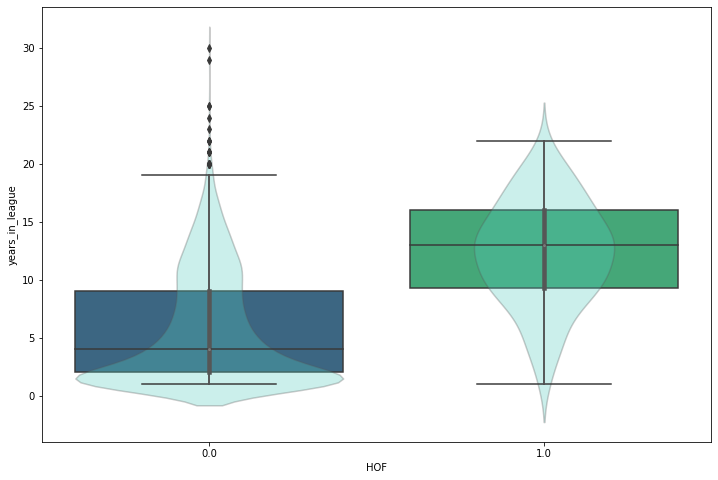

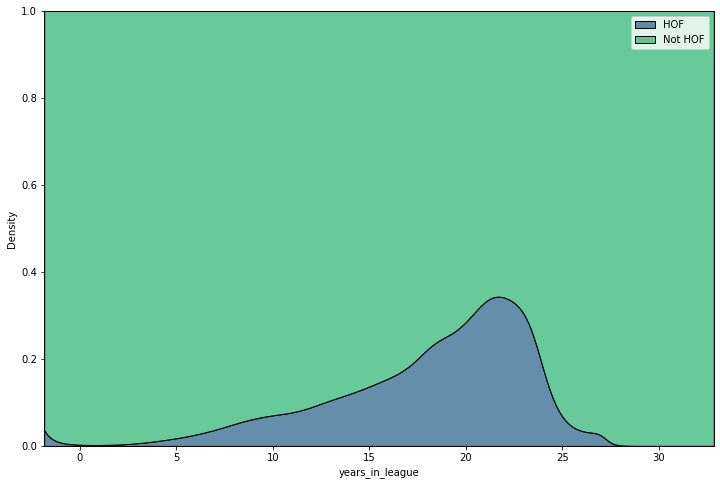

Pearson correlation of ppg to target HOF: 0.4404764573677337


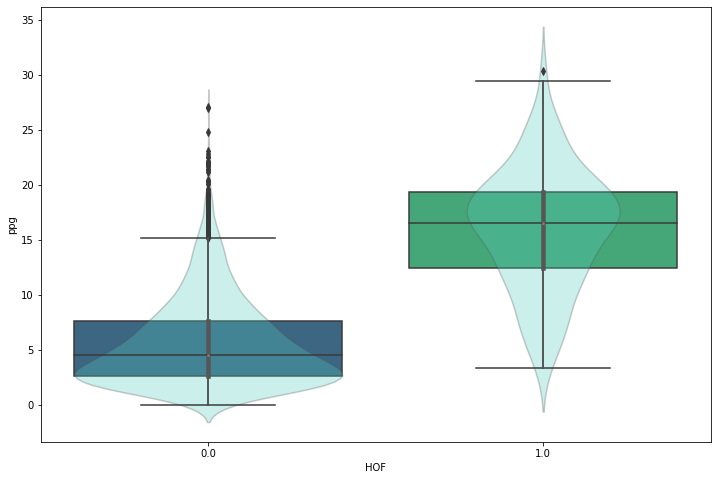

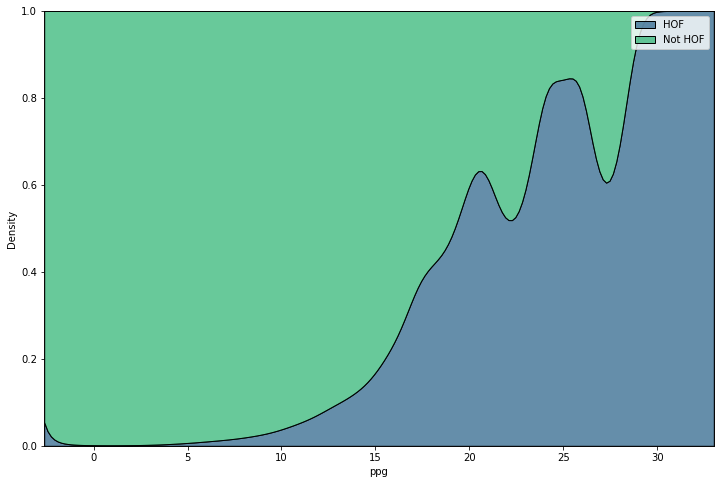

Pearson correlation of championship_average to target HOF: 0.1531763935682394


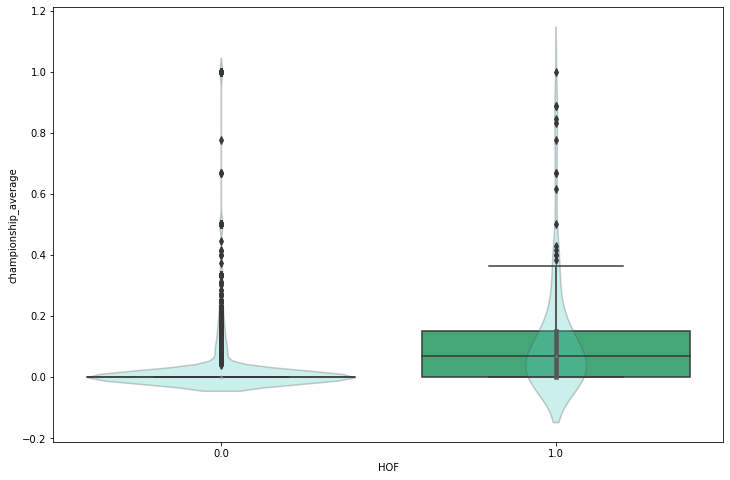

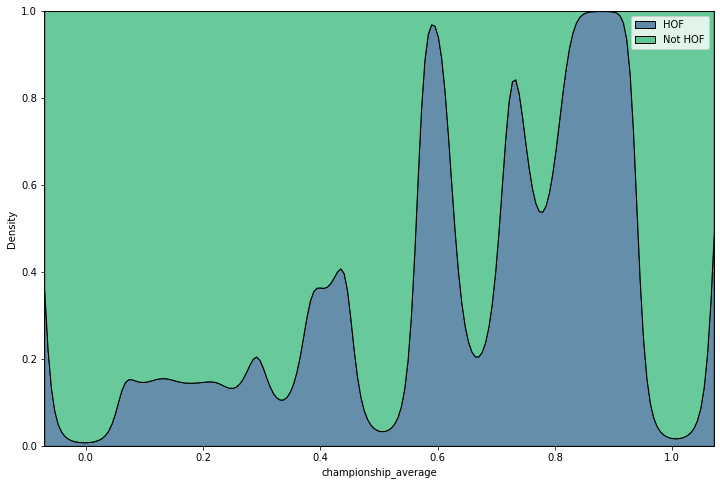

Pearson correlation of G_total to target HOF: 0.3370836562427302


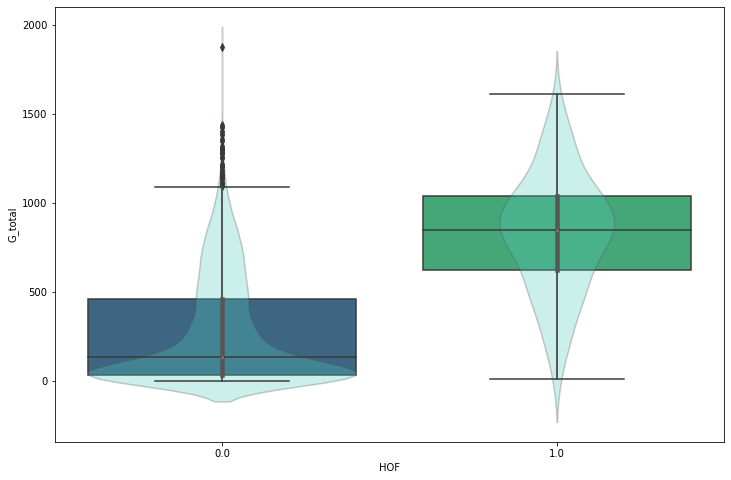

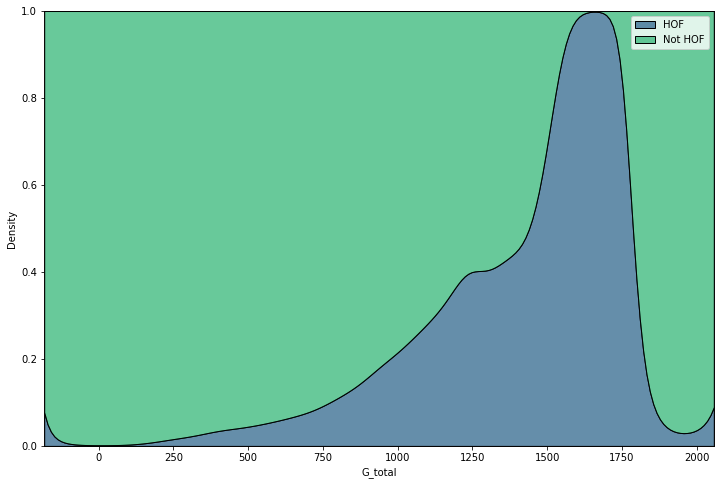

Pearson correlation of GS_total to target HOF: 0.22380720626725167


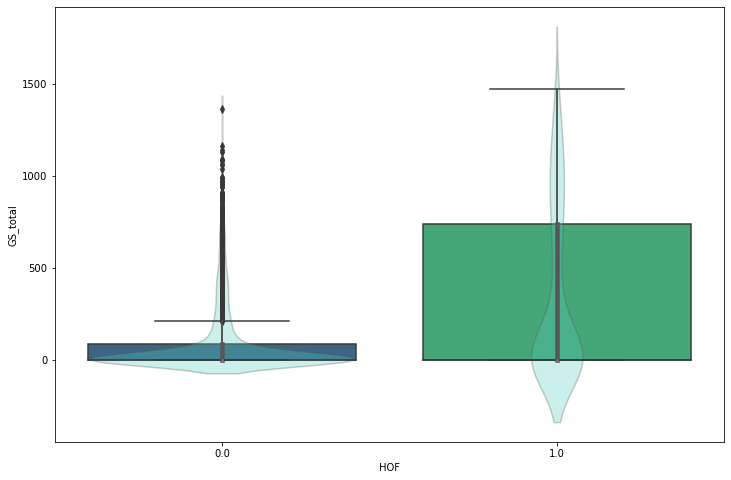

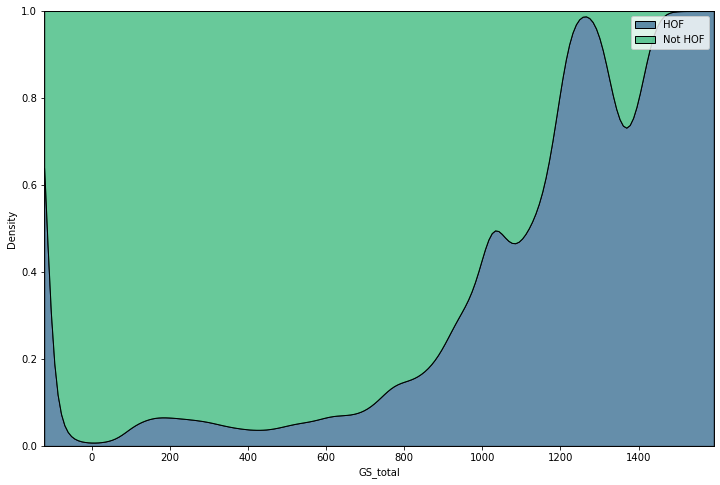

Pearson correlation of MP_total to target HOF: 0.4220934702012692


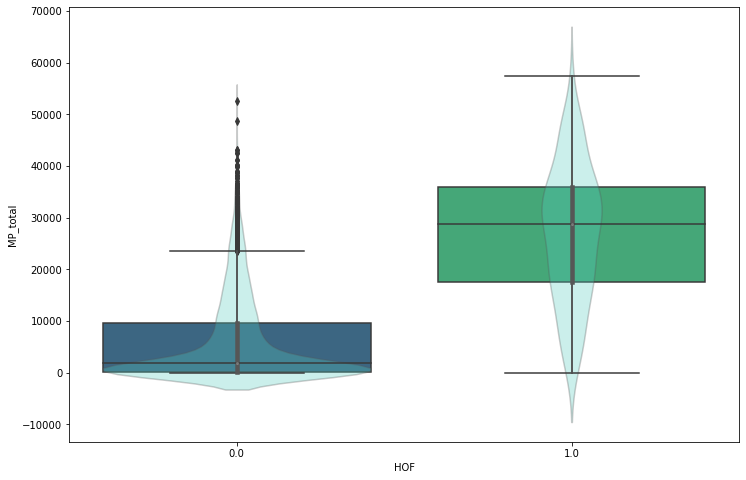

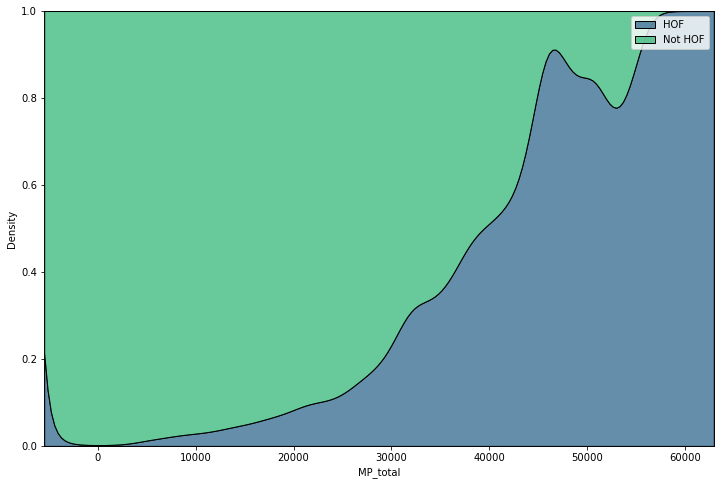

Pearson correlation of OWS_total to target HOF: 0.526697586406043


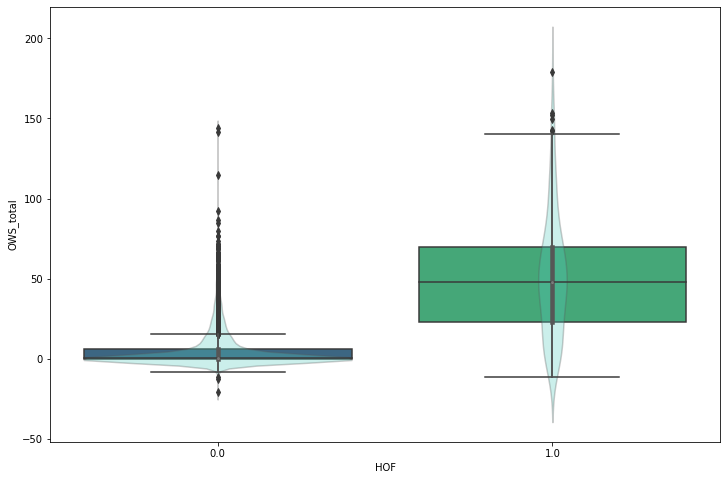

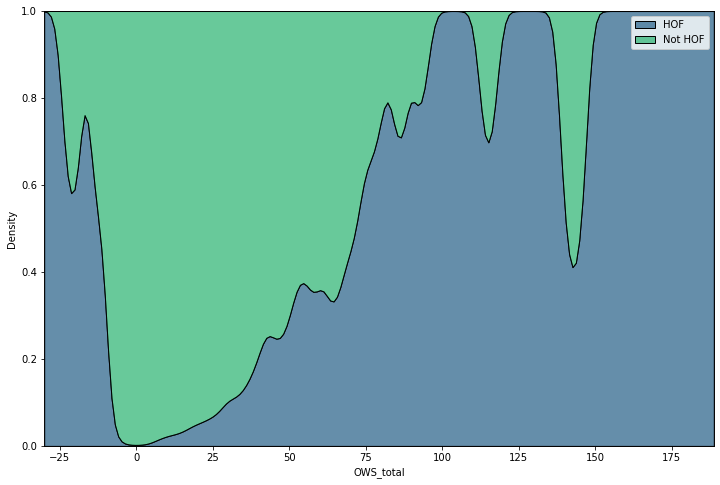

Pearson correlation of DWS_total to target HOF: 0.4904400691703006


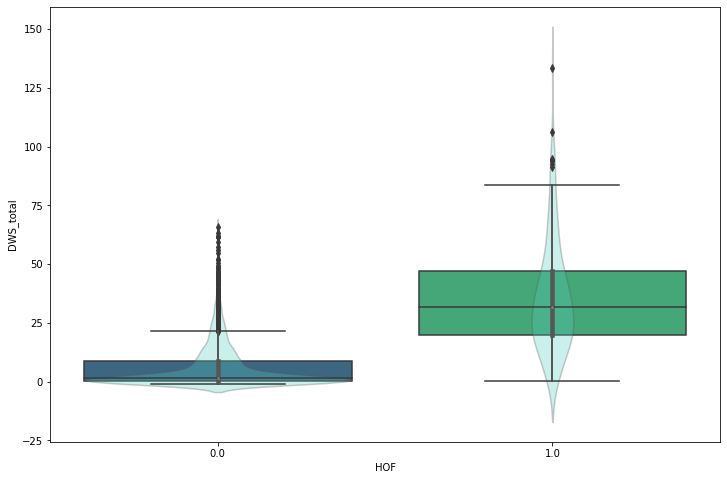

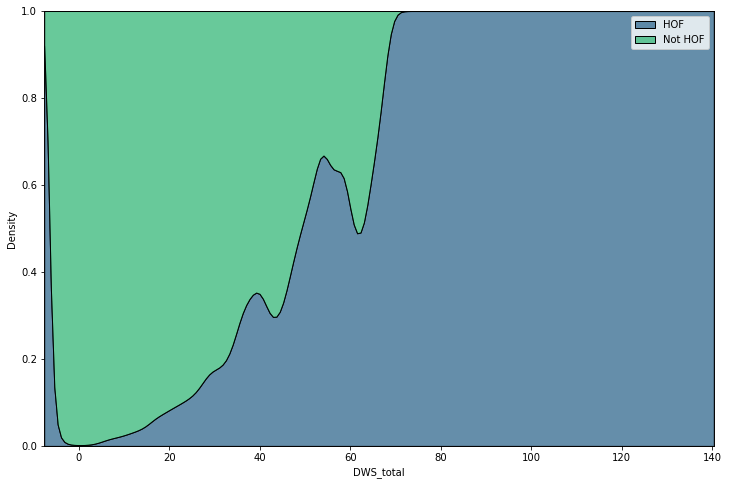

Pearson correlation of WS_total to target HOF: 0.5413556199332346


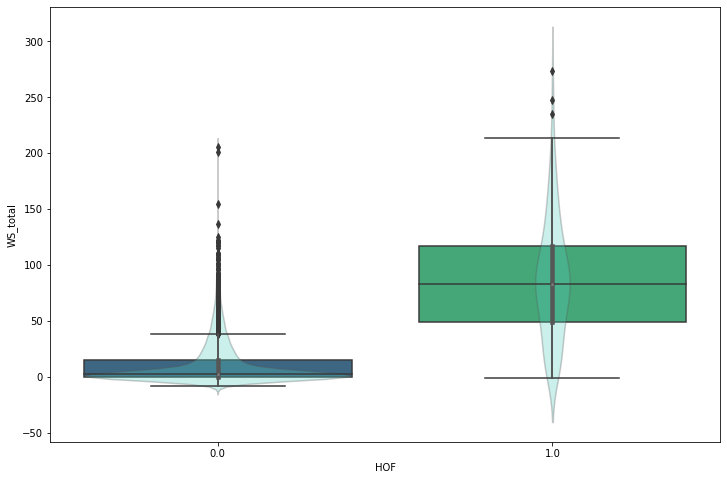

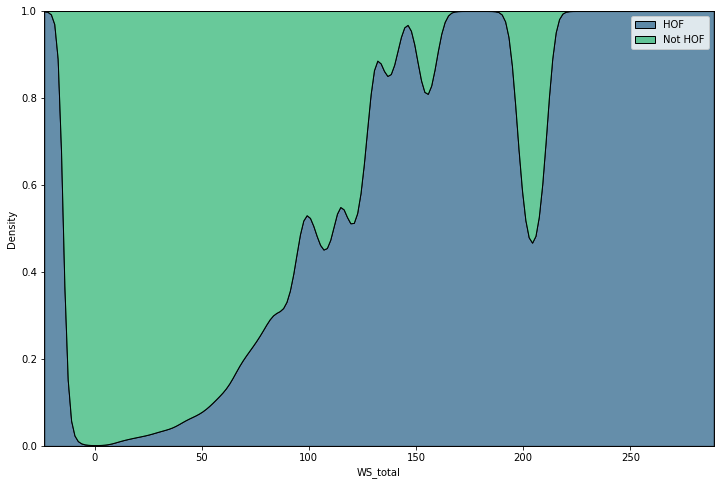

Pearson correlation of VORP_total to target HOF: 0.3956304057478851


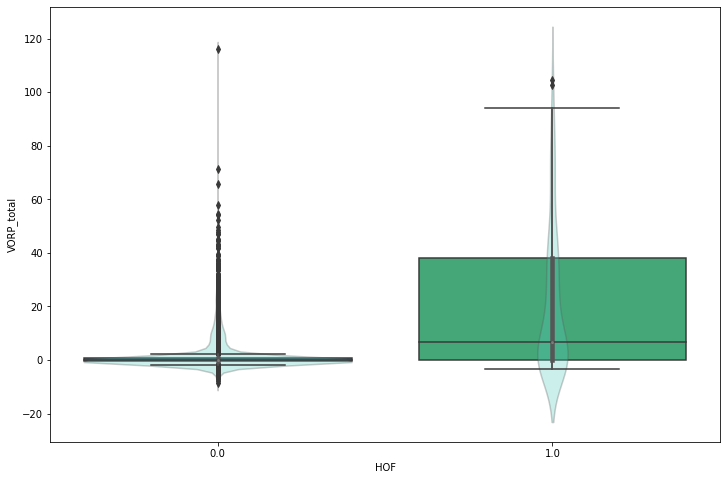

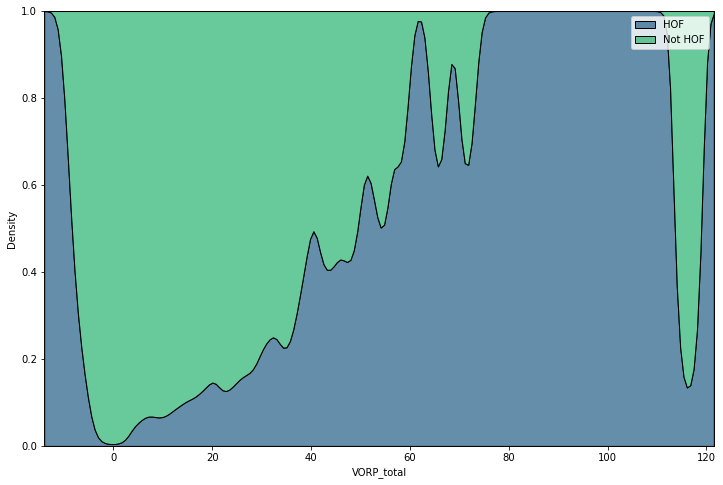

Pearson correlation of FG_total to target HOF: 0.4902192848280272


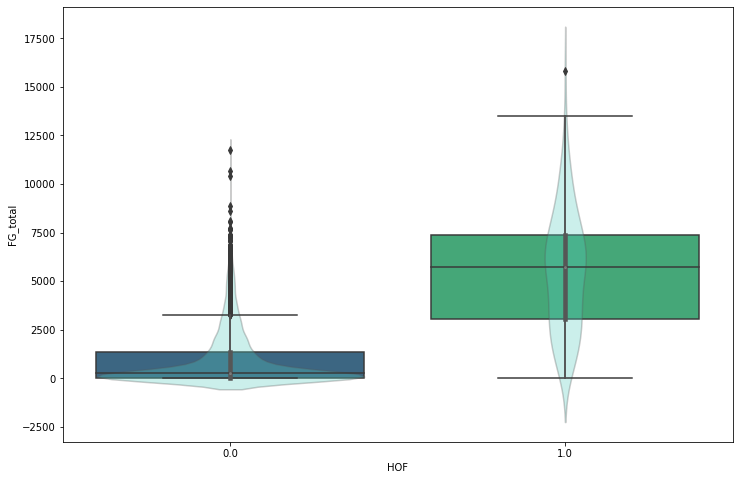

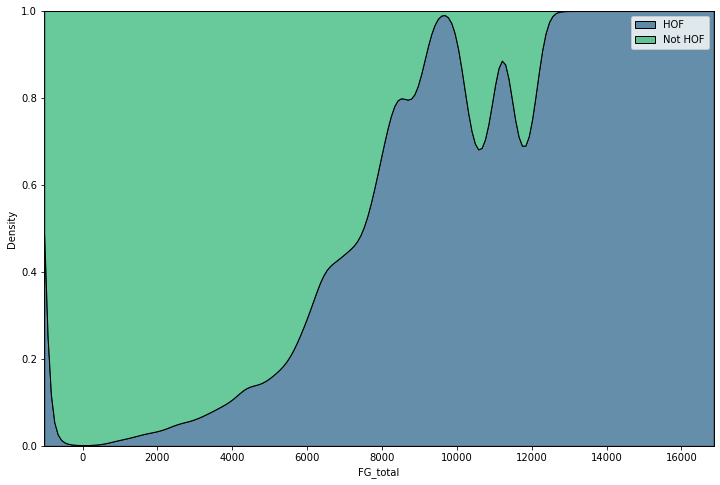

Pearson correlation of FGA_total to target HOF: 0.48662913108117156


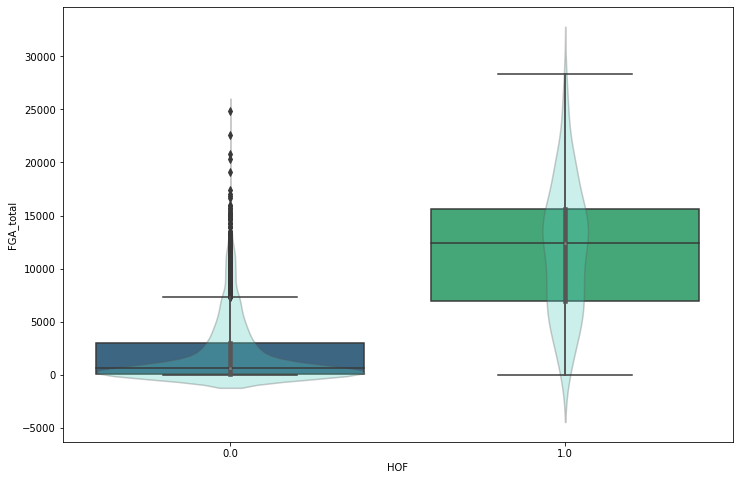

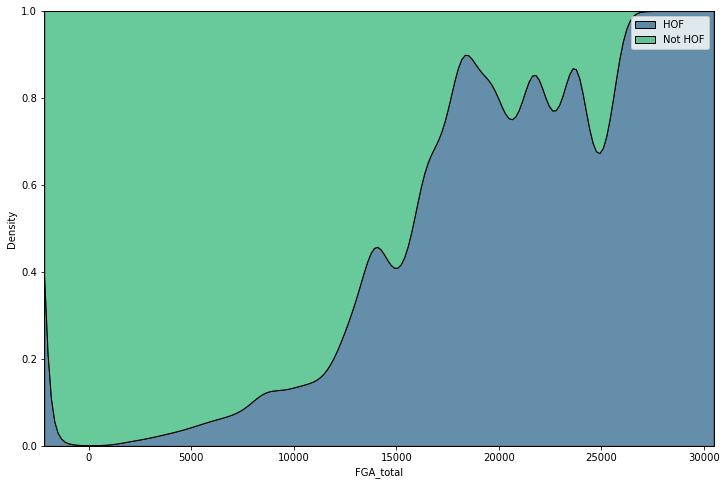

Pearson correlation of 3P_total to target HOF: 0.06882611954474228


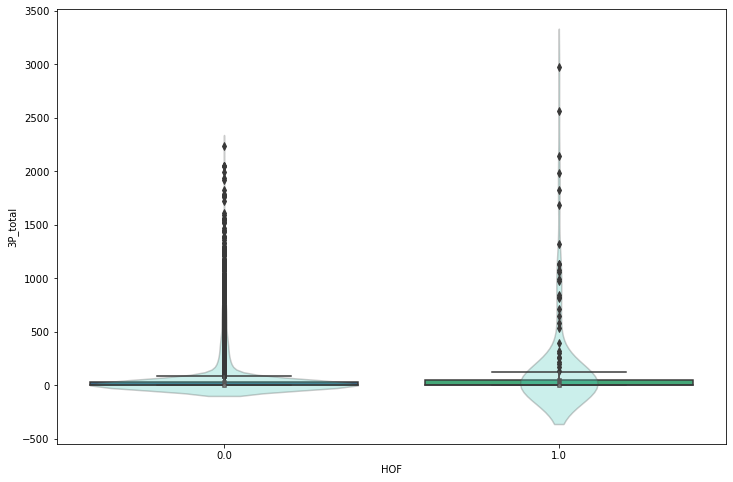

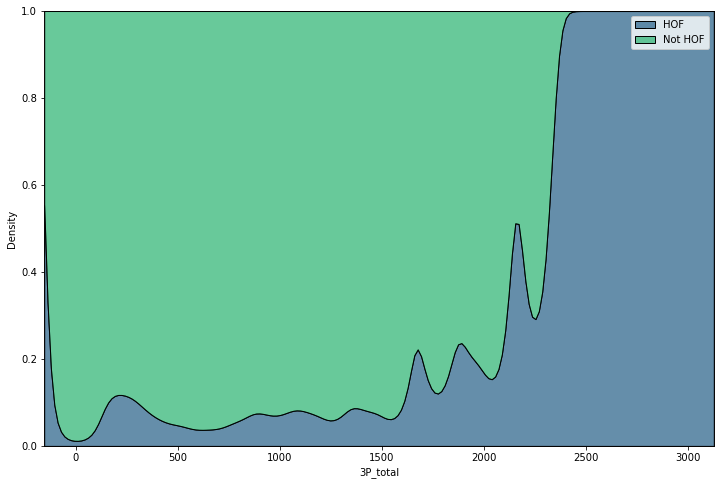

Pearson correlation of 3PA_total to target HOF: 0.07406673867863414


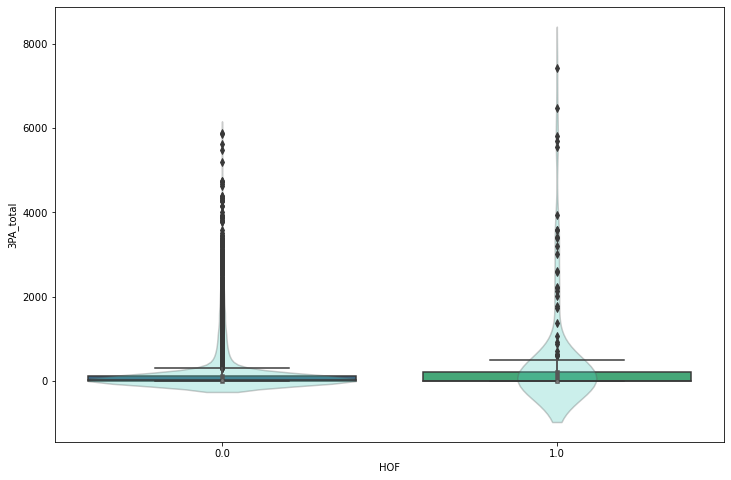

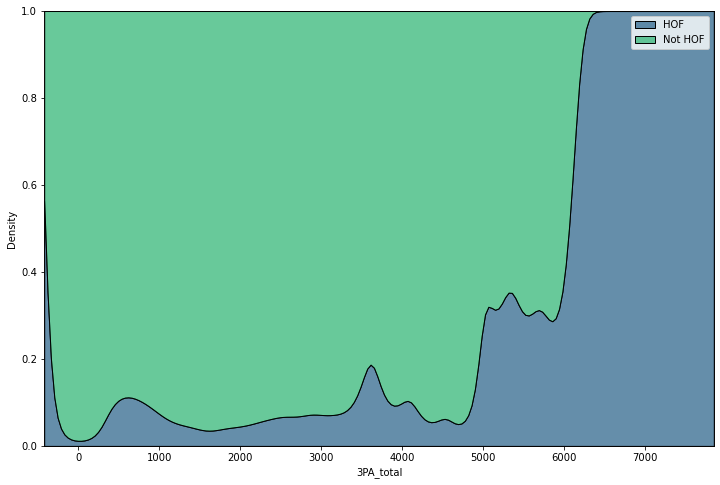

Pearson correlation of 2P_total to target HOF: 0.5128623933897775


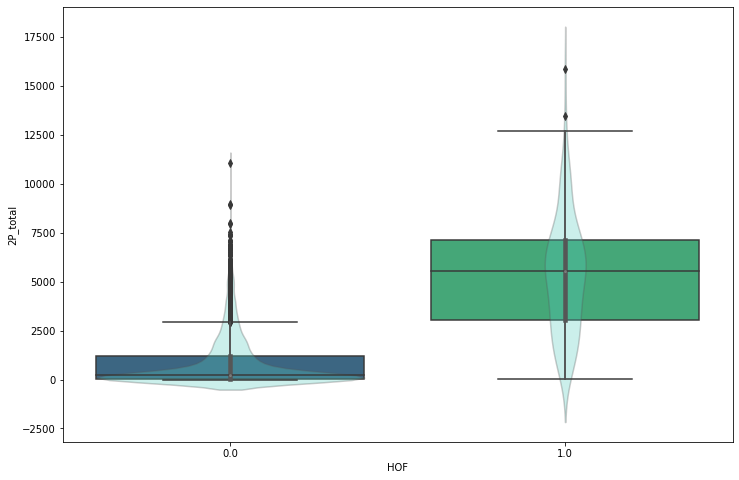

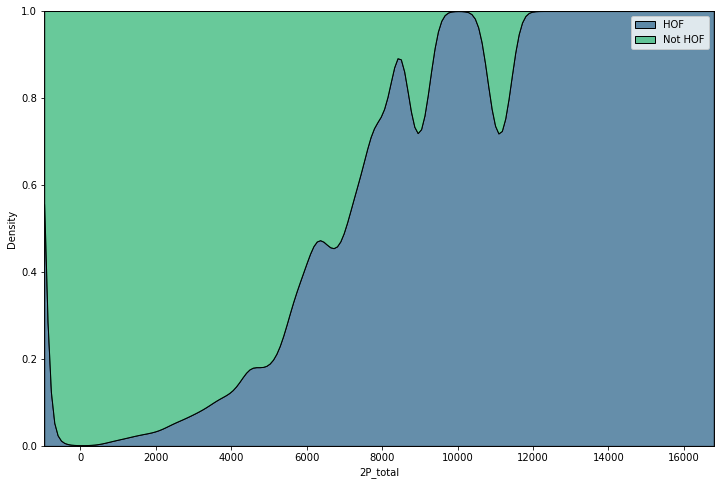

Pearson correlation of 2PA_total to target HOF: 0.5192408418787982


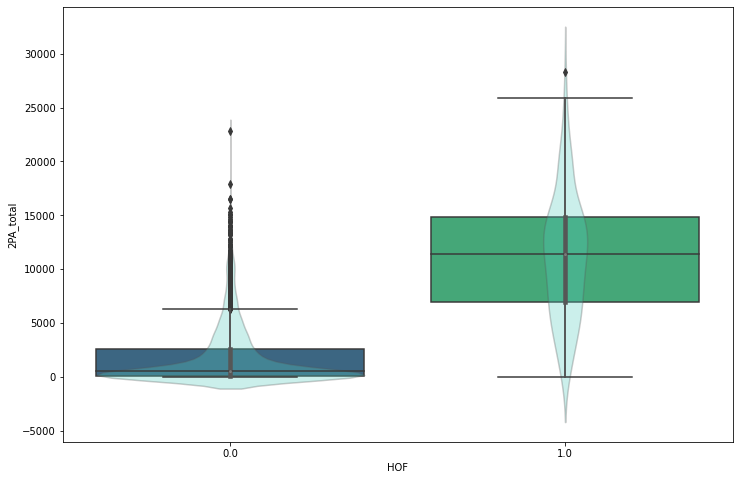

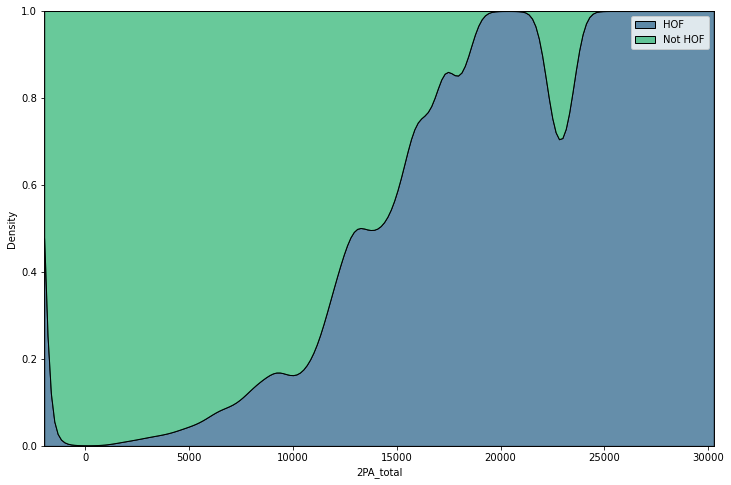

Pearson correlation of FT_total to target HOF: 0.5411534696425903


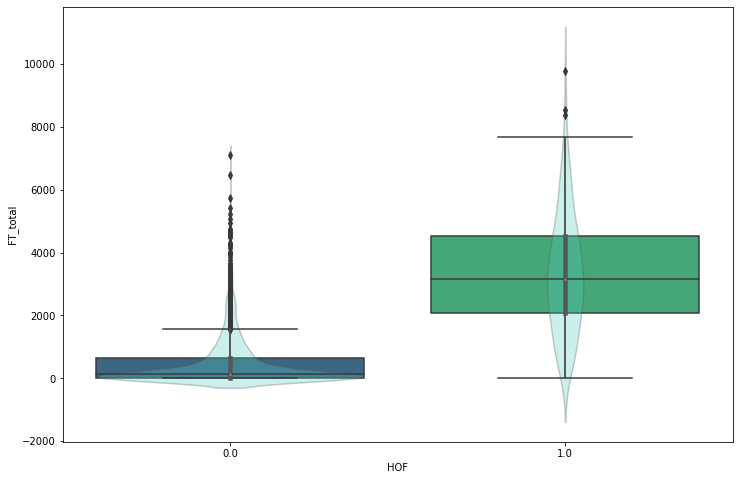

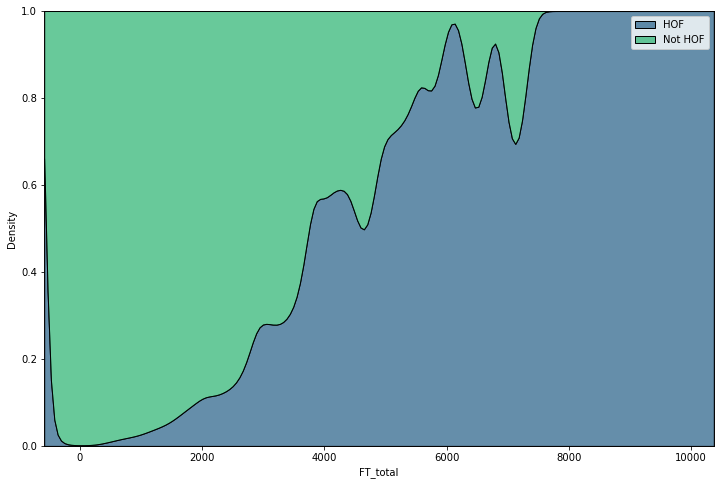

Pearson correlation of FTA_total to target HOF: 0.5434019193342383


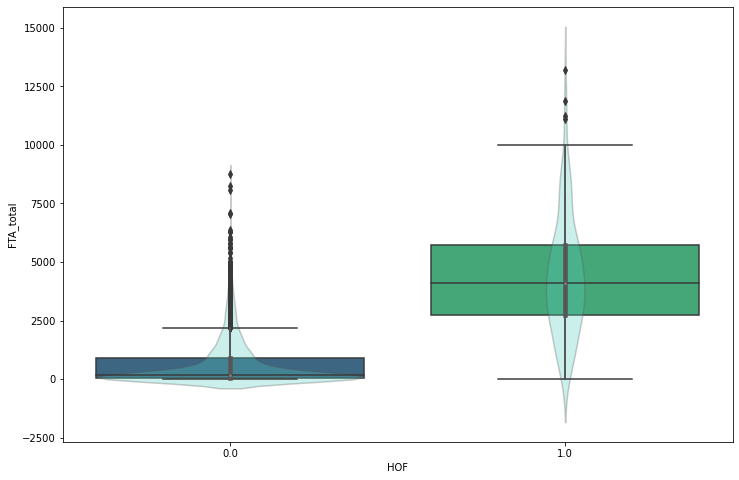

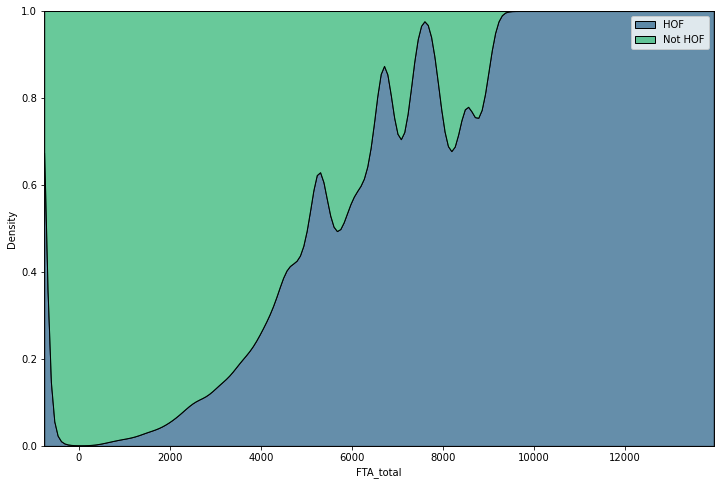

Pearson correlation of ORB_total to target HOF: 0.24500034117560468


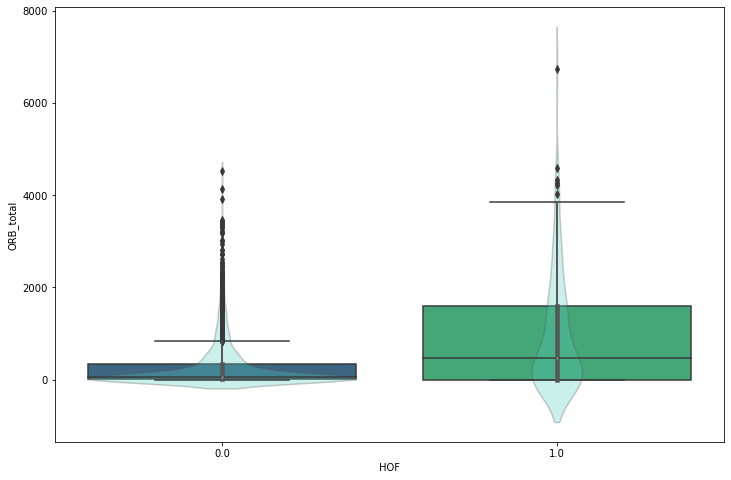

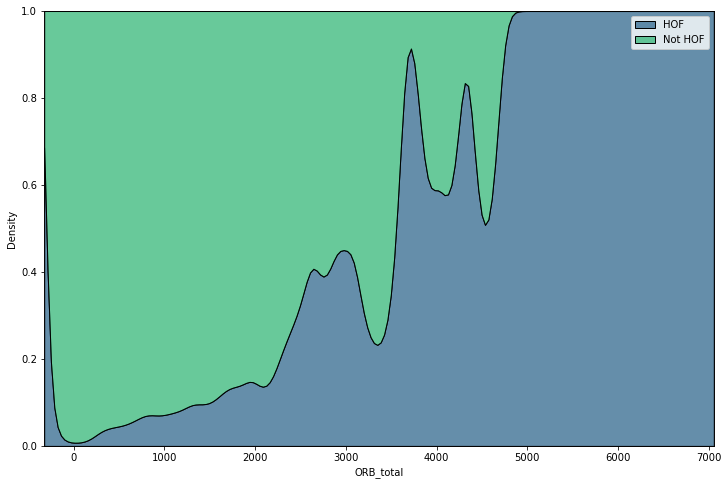

Pearson correlation of DRB_total to target HOF: 0.27796312028950215


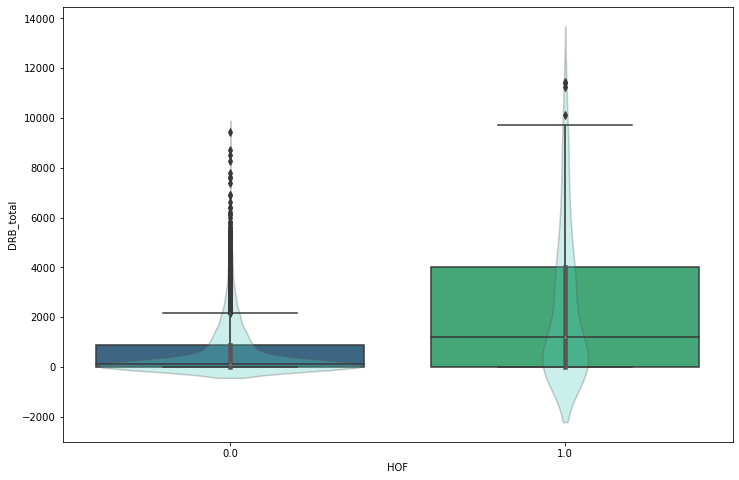

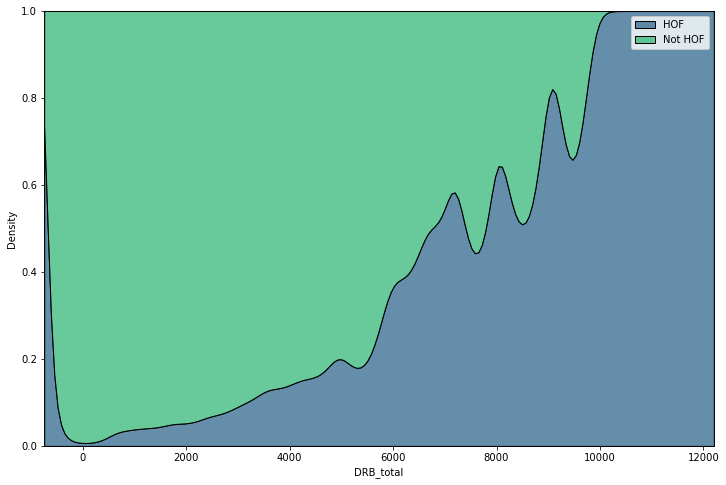

Pearson correlation of TRB_total to target HOF: 0.46232075325021443


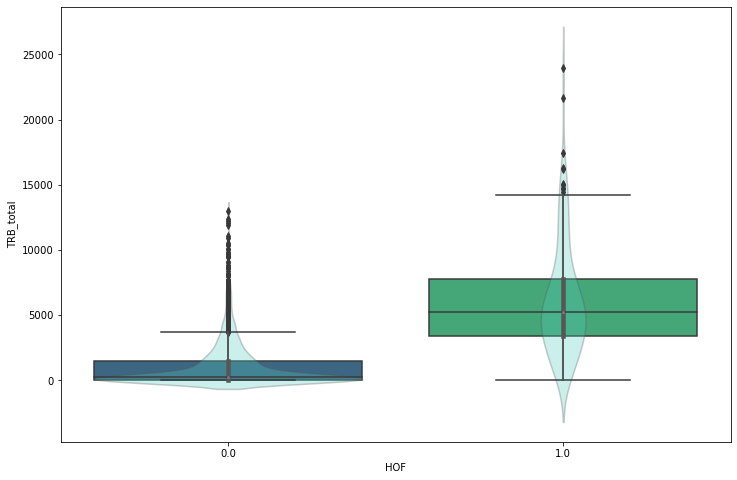

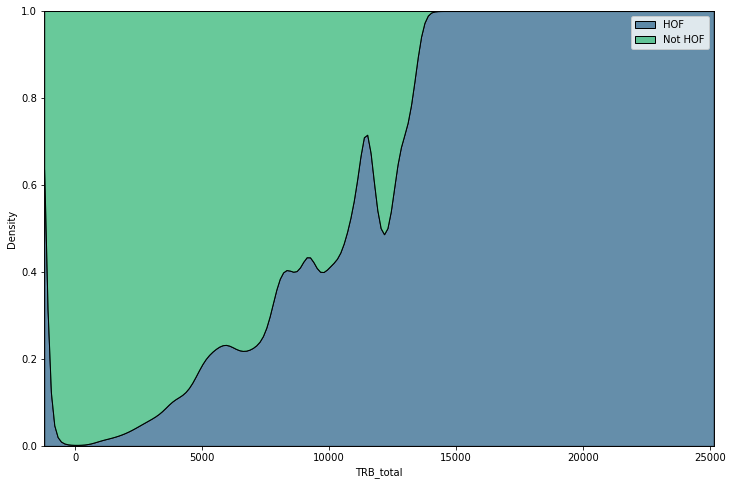

Pearson correlation of AST_total to target HOF: 0.40317059367383445


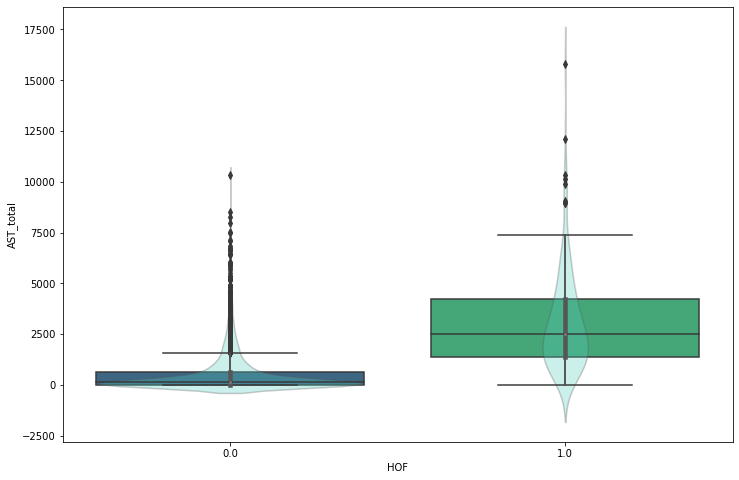

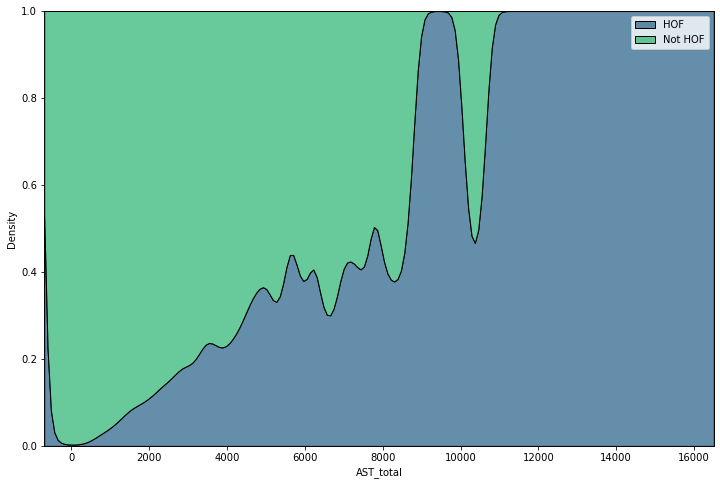

Pearson correlation of STL_total to target HOF: 0.2592947417031011


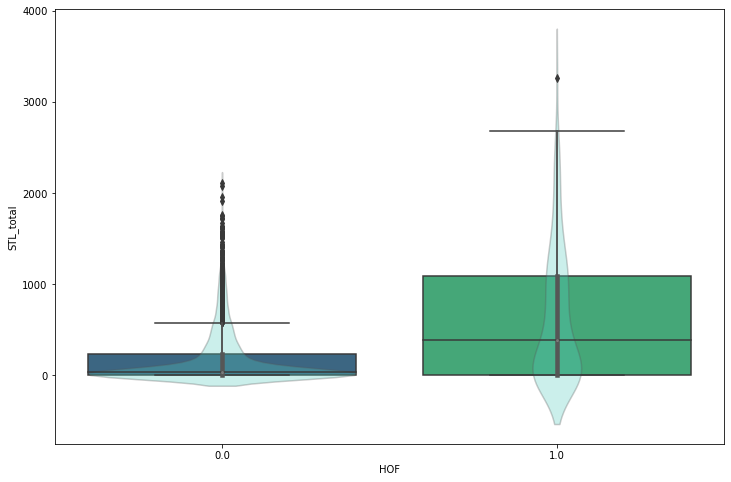

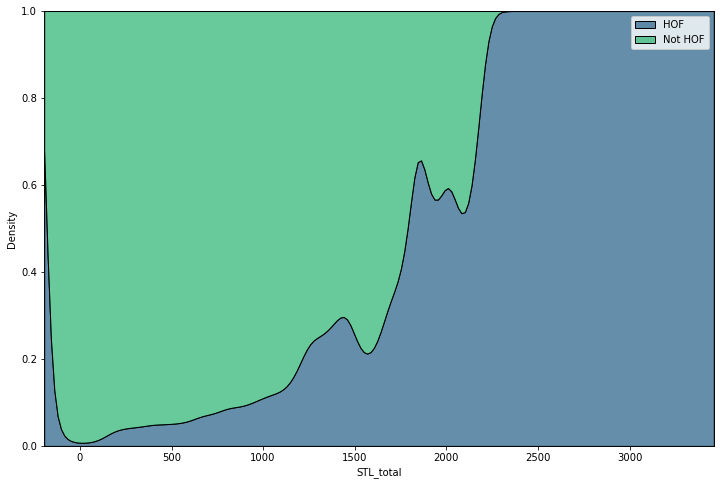

Pearson correlation of BLK_total to target HOF: 0.25390540336991685


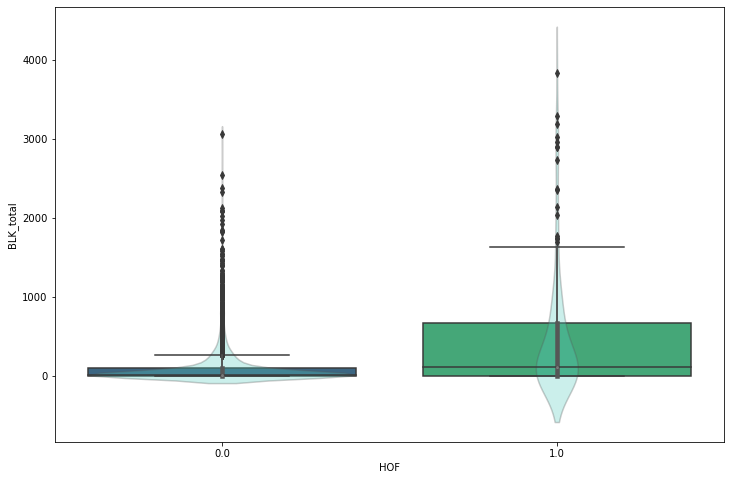

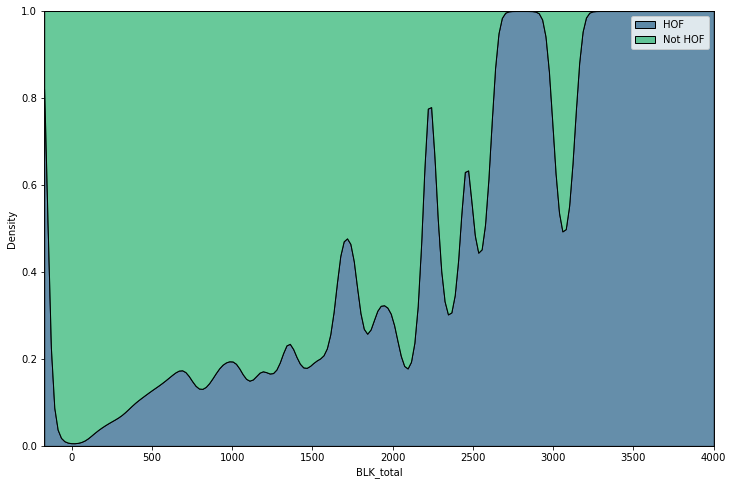

Pearson correlation of TOV_total to target HOF: 0.2629411990238913


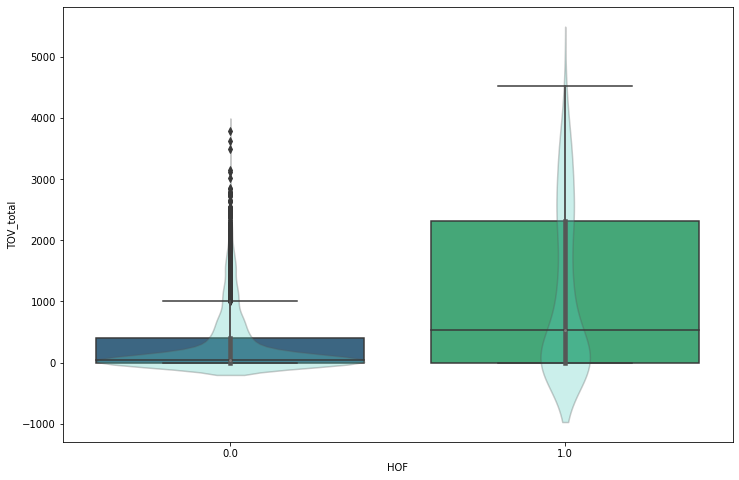

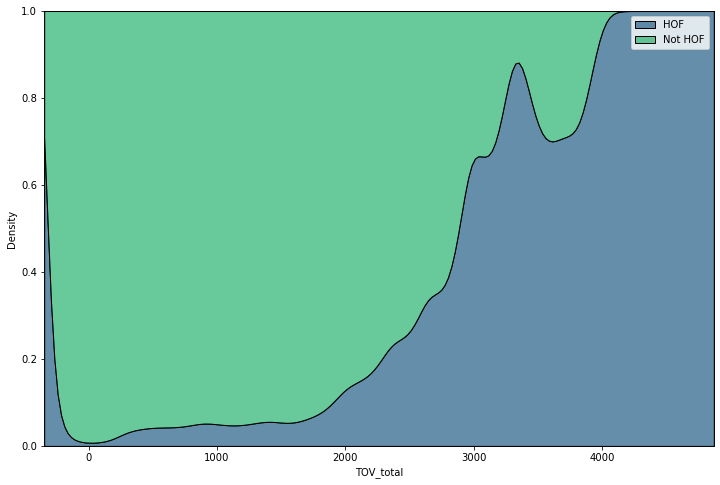

Pearson correlation of PF_total to target HOF: 0.3951529492139091


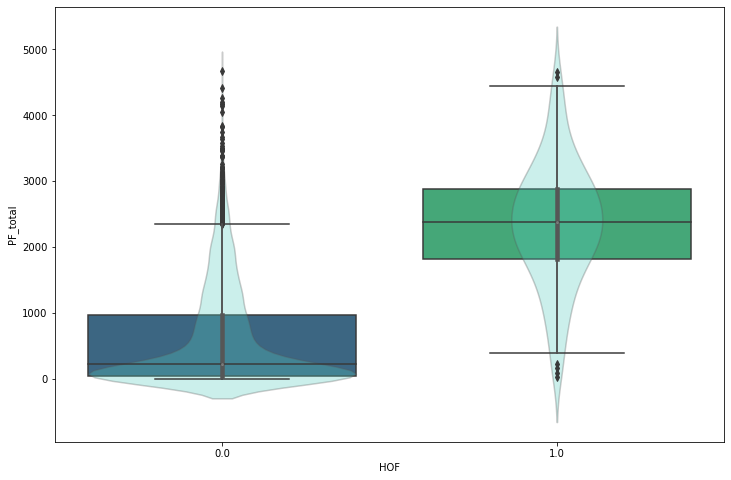

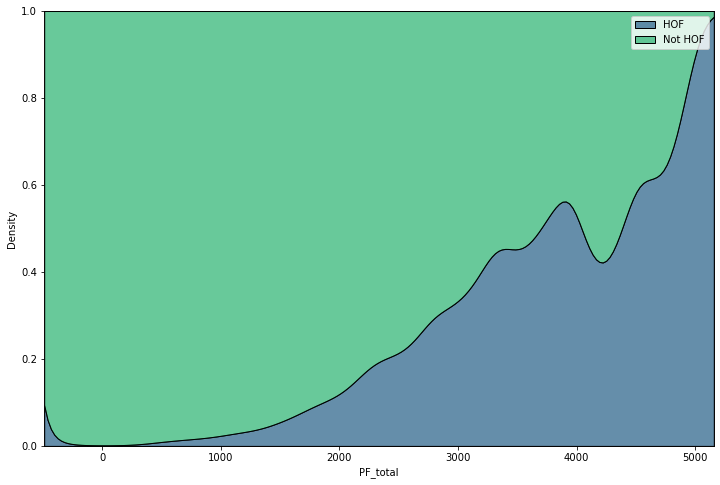

Pearson correlation of PTS_total to target HOF: 0.49549858771513033


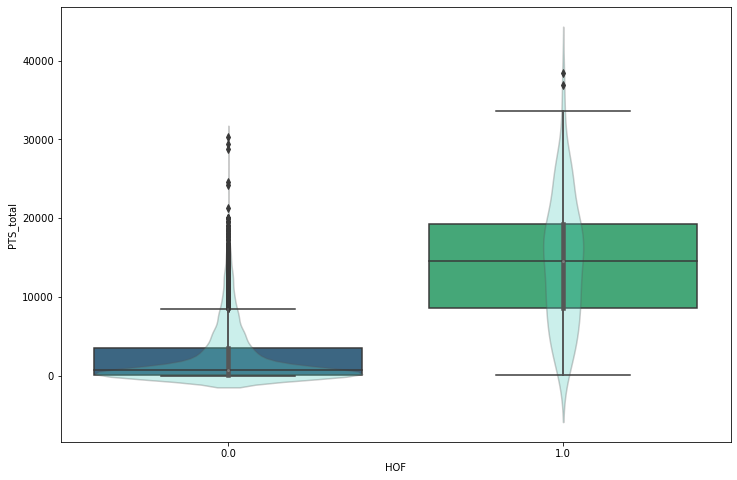

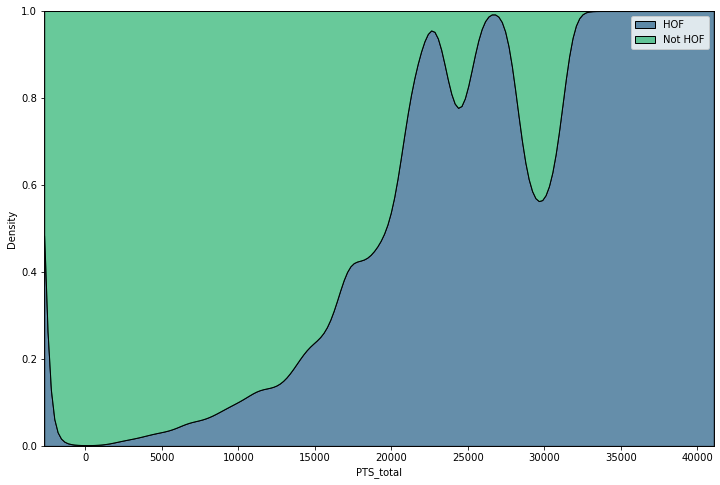

Pearson correlation of WOR_Year_total to target HOF: 0.3901562734577808


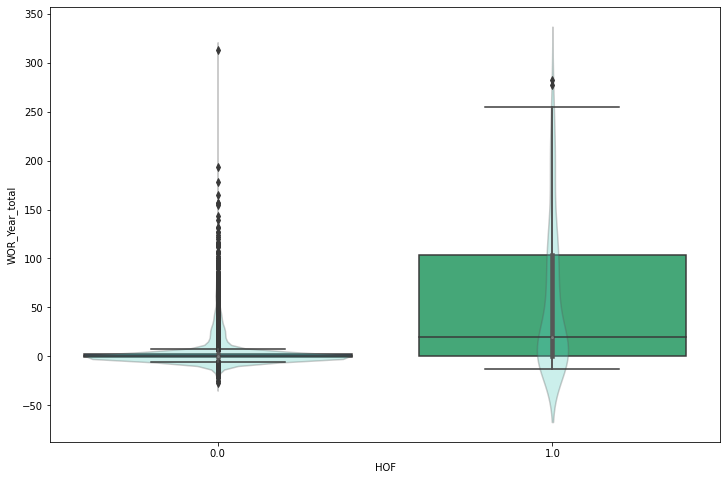

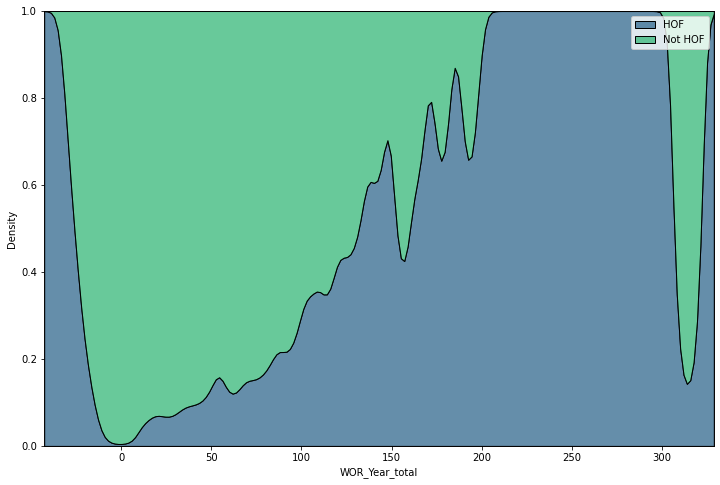

Pearson correlation of championship_total to target HOF: 0.3499243017307592


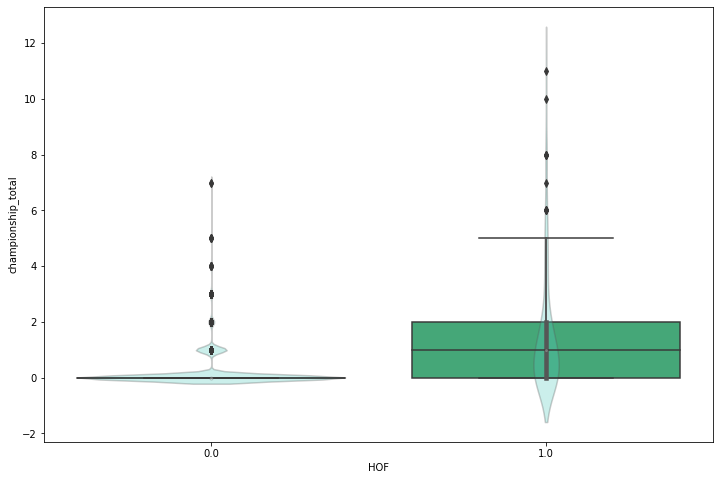

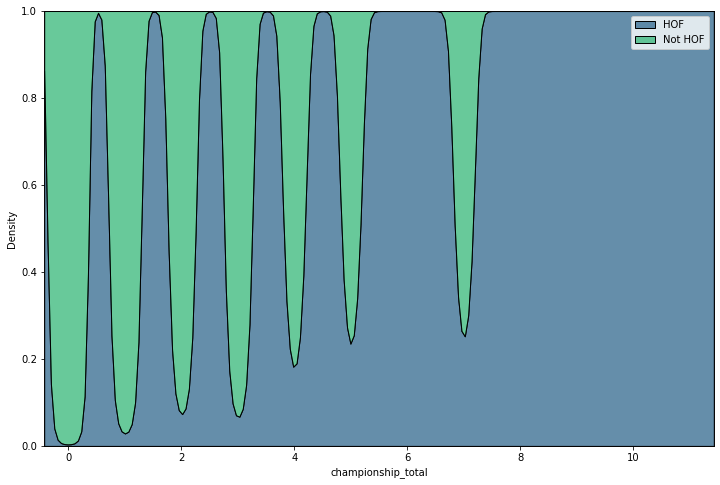

In [409]:
continuous_cols = [col for col in career_df.columns.values if col not in ['player_key','HOF']]

for col in continuous_cols:
    print("Pearson correlation of {} to target HOF: {}".format(col, career_df[col].corr(career_df.HOF)))
    univariate_swarm_boxplot(career_df, 'HOF', col)
    univariate_cdplot(career_df, 'HOF', col)

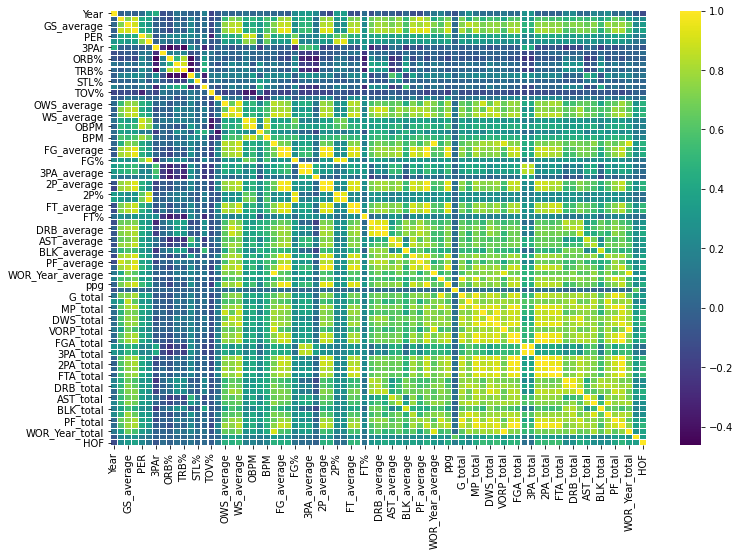

In [410]:
plt.figure(figsize = (12,8))
sns.heatmap(career_df[continuous_cols + ["HOF"]].corr(), linewidths = 0.1, cmap = "viridis")
# params not used annot = True, fmt=".2"
plt.show()

# Modeling
### train test holdout set

In [445]:
def get_train_test_holdout(model_df):
    model_df = model_df.sample(frac=1, random_state = 30).reset_index(drop=True)
    X = model_df
    y = model_df[["HOF"]].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 30 )
    # for holdout set take piece of train 0.125 x 0.8 = 0.1 of whole set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state= 30 ) 
    target_weight = (len(y_train) - y_train[:,0].sum()) / y_train[:,0].sum()
    
    return X_train, y_train, X_test, y_test, X_val, y_val, target_weight
    
def model_summary(model, X_train, y_train, X_test, y_test, threshold = 0.5):
    # train set predictions
    train_pred_prob = model.predict_proba(X_train)[:,1]
    train_pred = (train_pred_prob > threshold).astype("int")
    # test set predictions
    test_pred_prob = model.predict_proba(X_test)[:,1]
    test_pred = (test_pred_prob > threshold).astype("int")
    # model report
    print("Confusion Matrix for Test Set")
    print(confusion_matrix(y_test, test_pred))
    
    print("\n Classification Report for Test Set")
    print(classification_report(y_test, test_pred))
    
    print("Accuracy Train: {:.4f}".format(accuracy_score(y_train, train_pred)))
    print("AUC Train: {}".format(roc_auc_score(y_train, train_pred)))
    print("Accuracy Test: {:.4f}".format(accuracy_score(y_test, test_pred)))
    print("AUC Test: {}".format(roc_auc_score(y_test, test_pred)))
    
def plot_roc_curve(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred_pred = model.predict(X_test)
    test_auc = roc_auc_score(y_test, y_pred_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label = "AUC = {:.3f}".format(test_auc))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.title("ROC Plot")
    plt.legend(loc = "lower right")
    plt.show()

In [446]:
X_train, y_train, X_test, y_test, X_val, y_val, target_weight = get_train_test_holdout(career_df)

## XGBoost

[17:59:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Simple XGBoost Result
Confusion Matrix for Test Set
[[750   9]
 [ 10  21]]

 Classification Report for Test Set
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       759
         1.0       0.70      0.68      0.69        31

    accuracy                           0.98       790
   macro avg       0.84      0.83      0.84       790
weighted avg       0.98      0.98      0.98       790

Accuracy Train: 1.0000
AUC Train: 1.0
Accuracy Test: 0.9759
AUC Test: 0.832780823664414


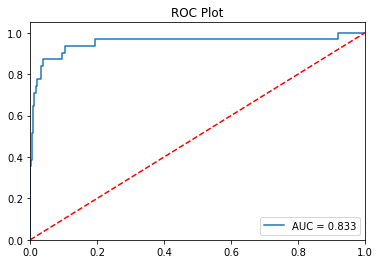

In [447]:
# baseline XGB
seed = 30
simple_xgb = xgb.XGBClassifier(random_state = seed, scale_pos_weight = target_weight)
simple_xgb.fit(X_train.drop(columns = ["HOF","player_key"]), y_train)
simple_xgb_pred_prob = simple_xgb.predict_proba(X_test.drop(columns = ["HOF","player_key"]))[:,1]
simple_xgb_pred = simple_xgb.predict(X_test.drop(columns = ["HOF","player_key"]))

print("Simple XGBoost Result")
model_summary(simple_xgb, X_train.drop(columns = ["HOF","player_key"]), y_train,
              X_test.drop(columns = ["HOF","player_key"]), y_test)
plot_roc_curve(simple_xgb, X_test.drop(columns = ["HOF","player_key"]), y_test)

Confusion Matrix for Test Set
[[376   4]
 [  5  10]]

 Classification Report for Test Set
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       380
         1.0       0.71      0.67      0.69        15

    accuracy                           0.98       395
   macro avg       0.85      0.83      0.84       395
weighted avg       0.98      0.98      0.98       395

Accuracy Train: 1.0000
AUC Train: 1.0
Accuracy Test: 0.9772
AUC Test: 0.8280701754385964


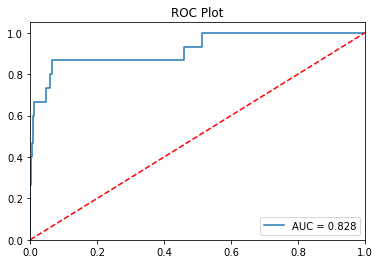

In [448]:
# holdout set results
val_pred = simple_xgb.predict(X_val.drop(columns = ["HOF","player_key"]))
val_pred_proba = simple_xgb.predict_proba(X_val.drop(columns = ["HOF","player_key"]))[:,1]

model_summary(simple_xgb, X_train.drop(columns = ["HOF","player_key"]), y_train,
              X_val.drop(columns = ["HOF","player_key"]), y_val)
plot_roc_curve(simple_xgb, X_val.drop(columns = ["HOF","player_key"]), y_val)

In [449]:
Xt = X_test.copy()
Xt['pred'] = simple_xgb_pred
Xt['pred_proba'] = simple_xgb_pred_prob
Xv = X_val.copy()
Xv['pred'] = val_pred
Xv['pred_proba'] = val_pred_proba
df_results = pd.concat([Xt,Xv], axis = 0)

In [450]:
df_results.loc[((df_results.HOF == 1)& (df_results.pred == 0))].sort_values(by = 'pred_proba')

player_key         Year  G_average  GS_average  \
1633     Phil JacksonSeptember 17, 1945  1974.333333  67.250000         NaN   
656      Louie DampierNovember 20, 1944  1978.000000  77.333333         NaN   
2974           Mel DanielsJuly 20, 1944  1977.000000  11.000000         NaN   
2003         Bob HoubregsMarch 12, 1932  1955.800000  43.400000         NaN   
2305  Buddy JeannetteSeptember 15, 1917  1950.000000  37.000000         NaN   
176        Carl BraunSeptember 25, 1927  1956.818182  62.181818         NaN   
1348          Wayne EmbryMarch 26, 1937  1964.000000  75.545455         NaN   
2876       Dick McGuireJanuary 25, 1926  1955.000000  67.090909         NaN   
2649        Vlade DivacFebruary 3, 1968  1997.500000  70.875000   61.187500   
3031    Maurice CheeksSeptember 8, 1956  1986.250000  68.812500   56.615385   
2079       Dikembe MutomboJune 25, 1966  2000.526316  62.947368   52.473684   
2788          Al CerviFebruary 12, 1917  1951.500000  50.500000         NaN   
1336      Spencer HaywoodApril 22, 1949  1976.846154  58.461538   44.000000   
1563  Sidney MoncriefSeptember 21, 1957  1985.090909  69.727273   57.000000   
911            Tom GolaJanuary 13, 1933  1961.545455  63.454545         NaN   

       MP_average        PER       TS%      3PAr       FTr       ORB%  \
1633  1183.416667  11.858333  0.518917  0.043000  0.378917   6.071429   
656   1477.000000  12.466667  0.510000       NaN  0.159333   1.633333   
2974   126.000000  10.700000  0.432000       NaN  0.657000   7.600000   
2003  1079.800000  16.220000  0.458000       NaN  0.478400        NaN   
2305          NaN        NaN  0.467000       NaN  0.899000        NaN   
176   1840.900000  15.210000  0.466818       NaN  0.324818        NaN   
1348  1978.454545  14.800000  0.476364       NaN  0.415545        NaN   
2876  1907.777778  15.466667  0.454636       NaN  0.541727        NaN   
2649  2114.875000  17.206250  0.538000  0.037438  0.397063  10.075000   
3031  2177.812500  16.137500  0.571312  0.024533  0.307813   2.268750   
2079  1936.368421  16.268421  0.565368  0.000211  0.623579  12.405263   
2788   575.500000  20.100000  0.539500       NaN  0.945500        NaN   
1336  1969.230769  16.746154  0.513846  0.004667  0.297077   8.610000   
1563  2104.545455  17.745455  0.588364  0.068818  0.518273   6.681818   
911   2048.090909  13.772727  0.493909       NaN  0.370727        NaN   

           DRB%       TRB%       AST%      STL%      BLK%       TOV%  \
1633  15.000000  11.240000   8.283333  1.500000  1.142857  19.566667   
656    4.866667   3.300000  18.433333  1.733333  0.400000  12.300000   
2974  20.300000  13.700000   7.000000  1.100000  4.900000        NaN   
2003        NaN        NaN        NaN       NaN       NaN        NaN   
2305        NaN        NaN        NaN       NaN       NaN        NaN   
176         NaN        NaN        NaN       NaN       NaN        NaN   
1348        NaN        NaN   6.680000       NaN       NaN        NaN   
2876        NaN        NaN        NaN       NaN       NaN        NaN   
2649  20.468750  15.337500  16.037500  1.956250  2.987500  17.381250   
3031   7.475000   4.918750  28.587500  3.156250  0.450000  17.568750   
2079  25.847368  19.194737   4.368421  0.657895  6.178947  17.689474   
2788        NaN        NaN        NaN       NaN       NaN        NaN   
1336  17.560000  13.453846   7.607692  0.830000  1.820000  14.583333   
1563  10.045455   8.372727  16.672727  1.881818  0.572727  13.927273   
911         NaN        NaN  19.050000       NaN       NaN        NaN   

           USG%  OWS_average  DWS_average  WS_average     WS/48      OBPM  \
1633  12.533333     0.858333     1.583333    2.425000  0.096667 -1.485714   
656   15.250000     1.633333     0.633333    2.266667  0.075667 -1.233333   
2974        NaN    -0.200000     0.200000    0.000000 -0.002000 -5.400000   
2003        NaN     2.040000     0.800000    2.860000  0.102600       NaN   
2305        NaN     1.900000     0.700000    2.600000    

In [451]:
df_results.loc[((df_results.HOF == 0)& (df_results.pred == 1))].sort_values(by = 'pred_proba', ascending = False)

player_key         Year  G_average  GS_average  \
2853   Rudy LaRussoNovember 11, 1937  1964.500000  73.600000         NaN   
1397           Pau GasolJuly 6, 1980  2009.411765  65.823529   63.588235   
105       Dirk NowitzkiJune 19, 1978  2008.000000  73.368421   71.736842   
2203    Clifford RayJanuary 21, 1949  1976.500000  78.400000         NaN   
3525    Joe GraboskiJanuary 15, 1930  1955.909091  69.272727         NaN   
171           Ray ScottJuly 12, 1938  1966.100000  68.400000         NaN   
1330    Larry NanceFebruary 12, 1959  1988.000000  65.714286   56.785714   
2039  Sidney WicksSeptember 19, 1949  1976.500000  76.000000         NaN   
2617    Tom MescheryOctober 26, 1938  1966.500000  77.800000         NaN   
2638    Jo Jo WhiteNovember 16, 1946  1975.769231  64.384615         NaN   
263       Ed ConlinSeptember 2, 1933  1959.000000  60.750000         NaN   
2266       Clark KelloggJuly 2, 1961  1985.000000  52.000000   48.200000   
3181      Paul HoffmanApril 12, 1925  1952.000000  60.500000         NaN   

       MP_average        PER       TS%      3PAr       FTr       ORB%  \
2853  2448.700000  15.280000  0.502800       NaN  0.456300        NaN   
1397  2284.058824  21.452941  0.567647  0.026941  0.400176   8.488235   
105   2561.736842  22.178947  0.572789  0.213579  0.348316   3.336842   
2203  1994.000000  13.700000  0.540700  0.002500  0.442900  10.300000   
3525  2219.700000  13.510000  0.409545       NaN  0.362818        NaN   
171   2133.900000  15.570000  0.459200       NaN  0.337400        NaN   
1330  2192.642857  19.600000  0.581714  0.004286  0.336143   8.850000   
2039  2576.200000  15.320000  0.496800  0.002500  0.373300   8.275000   
2617  2345.900000  13.080000  0.492600       NaN  0.329200        NaN   
2638  2303.153846  13.515385  0.482077  0.004000  0.182231   2.355556   
263   1424.000000  12.650000  0.423750       NaN  0.305250        NaN   
2266  1702.800000  17.340000  0.514200  0.035800  0.261200  10.800000   
3181  2230.000000  14.000000  0.406750       NaN  0.427000        NaN   

           DRB%       TRB%       AST%      STL%      BLK%       TOV%  \
2853        NaN        NaN   9.100000       NaN       NaN        NaN   
1397  21.747059  15.211765  16.523529  0.770588  3.511765  12.305882   
105   21.594737  12.536842  12.600000  1.231579  1.873684   8.678947   
2203  22.900000  17.410000  11.100000  1.425000  1.937500  24.500000   
3525        NaN        NaN        NaN       NaN       NaN        NaN   
171         NaN        NaN  10.357143       NaN       NaN        NaN   
1330  18.271429  13.650000  11.700000  1.385714  3.814286  11.521429   
2039  16.987500  12.800000  13.430000  1.450000  1.237500  20.050000   
2617        NaN  12.200000   7.471429       NaN       NaN        NaN   
2638   7.644444   5.225000  19.146154  1.666667  0.266667  16.540000   
263         NaN        NaN        NaN       NaN       NaN        NaN   
2266  18.540000  14.660000  14.060000  2.480000  0.580000  14.300000   
3181        NaN        NaN        NaN       NaN       NaN        NaN   

           USG%  OWS_average  DWS_average  WS_average     WS/48      OBPM  \
2853        NaN     3.590000     2.540000    6.140000  0.117200       NaN   
1397  23.441176     5.100000     2.964706    8.052941  0.168059  1.505882   
105   26.573684     7.452632     3.136842   10.594737  0.186947  2.815789   
2203  13.450000     1.960000     3.690000    5.670000  0.126000 -1.125000   
3525        NaN    -0.154545     2.400000    2.254545  0.049900       NaN   
171         NaN     0.510000     2.570000    3.090000  0.068200       NaN   
1330  20.635714     4.635714     3.185714    7.814286  0.167000  1.642857   
2039  17.275000     2.180000     2.030000    4.240000  0.071800 -0.175000   
2617        NaN     2.110000     2.260000    4.350000  0.088800       NaN   
2638  19.500000     1.569231     2.584615    4.138462  0.074000 -0.900000   
263         NaN     0.275000     1.475000    1.762500  0.053750       NaN   
2266 

In [452]:
# shap results for model
mybooster = simple_xgb.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfunc(self = None):
    return model_bytearray
mybooster.save_raw = myfunc

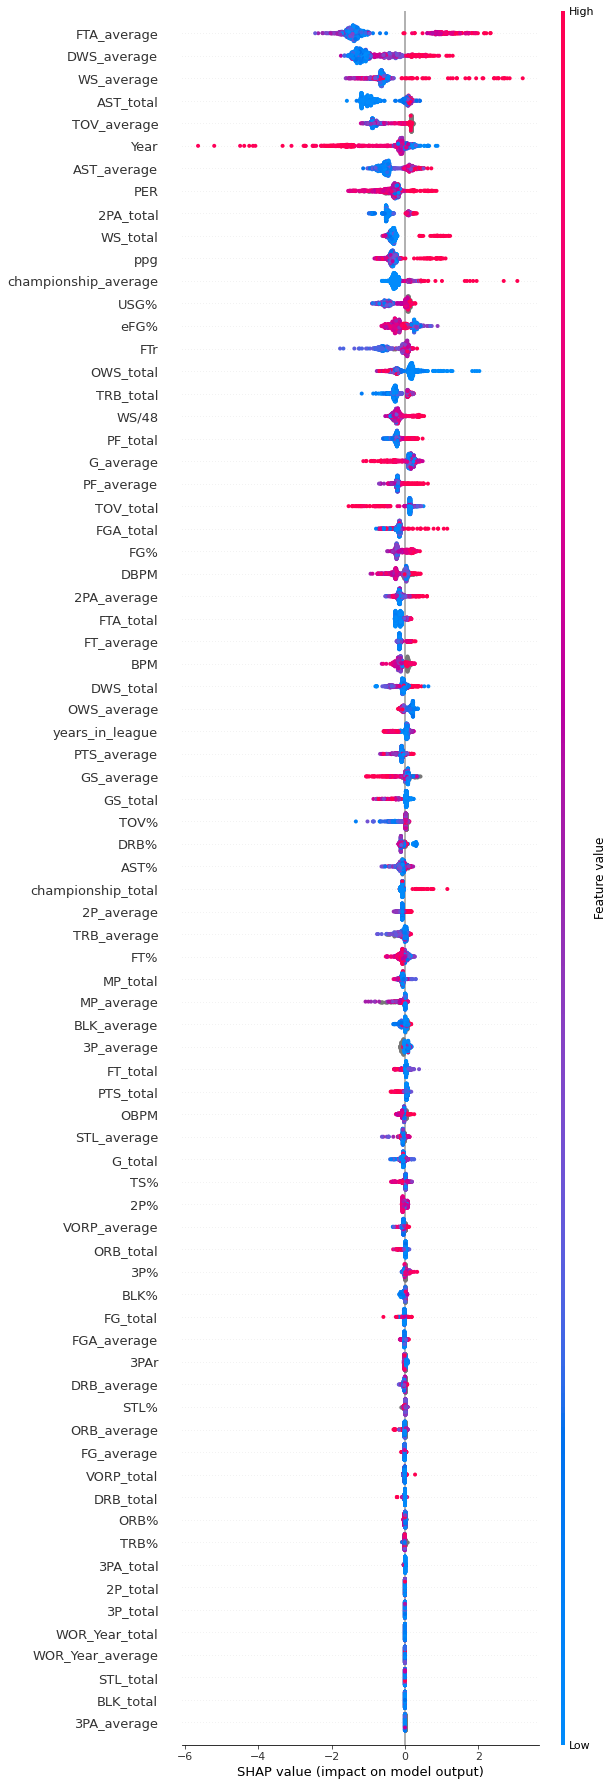

In [453]:
explainer = shap.TreeExplainer(mybooster)
simple_shap_values = explainer.shap_values(X_test.drop(columns = ["HOF","player_key"]))
shap.summary_plot(simple_shap_values, X_test.drop(columns = ["HOF","player_key"]), 
                  max_display = X_test.drop(columns = ["HOF","player_key"]).columns.nunique())